#### Train a Convolutional Neural Network model for predicting cardiac arrhythmias

#### Import necessary libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import seaborn as sns
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.models import load_model, Sequential
from keras.layers import BatchNormalization, Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#### Load the dataset.

In [2]:

df = None

# Consider only lead2
column_names = ["idx", "ecg_id", "lead2", "arrhythmia_code"]
dtypes = {"idx" : "int32", "ecg_id" : "str", "lead2" : "float16", "arrhythmia_code" : "int16"}

try:
    print("\nStart loading CSV file...")
    df = pd.read_csv("../dataset/csv_files/ecg_sph_dataset.csv", sep="|", dtype = dtypes, usecols = column_names)
    print("\nFinish loading CSV file...")
except Exception as e:
    print("\nFail to load CSV file.")
    print("Error: {}".format(e))



Start loading CSV file...

Finish loading CSV file...


#### Display the dataset size.

In [3]:

df.shape


(128850000, 4)

#### Build a helper function to convert the records to the required format to perform a time series processing.

In [4]:

number_of_steps = 1250
number_of_features = 1

def get_new_columns_order(column_names_array):
    column_idx_count = 0
    new_array = np.zeros(len(column_names_array), dtype = int)
    for column_idx in range(0, (number_of_steps * 4)):
        for column_idx_2 in range(0, number_of_features):
            new_array[column_idx + column_idx_2 * (number_of_steps * 4)] = column_idx_count
            column_idx_count += 1
    return new_array

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series.
    # The function groups each 1250 dataset records (CSV lines) into one record.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    All time windows (np.array)
    #    All target values (np.array)
    print("\nStarting build_time_window_structure function...")
    df["idx"] = df["idx"] % (number_of_steps * 4)
    df_aux = df.pivot_table(index = "ecg_id", columns = "idx", values = ["lead2"], aggfunc = "sum")
    new_columns = get_new_columns_order(df_aux.columns.values)
    df_aux.columns = list(new_columns)
    sorted_columns = sorted(df_aux.columns)
    df_modified = df_aux[sorted_columns]
    X_array = df_modified.values
    y_array = df["arrhythmia_code"].values
    y_array = y_array[::(number_of_steps * 4)]
    # Resample sample frequency to 125 hz.
    fs_original = 500 # Original frequency (Hz)
    fs_new = 125 # New frequency (Hz)
    downsampling_factor = int(fs_original / fs_new)
    nyquist_rate = fs_original / 2.0  # Nyquist rate
    cutoff_freq = fs_new / 2.0  # Cut off rate
    b, a = signal.butter(4, cutoff_freq / nyquist_rate, btype = "low")
    X_array_filtered = signal.filtfilt(b, a, X_array, axis = 1)
    X_array_125hz = X_array_filtered[:, ::downsampling_factor]
    print("\nShape of features: ", X_array_125hz.shape)
    print("Quantity os samples (labels): ", len(y_array))
    print("\nFinishing build_time_window_structure function.")
    return X_array_125hz, y_array


#### Build "time window" structure and show class distribution.

In [5]:

# Build "time window" structure to handle the dataset as a time series.
X_array, y_array = build_time_window_structure(df)
diagnostic_codes, count = np.unique(y_array, return_counts = True)
percentage_by_codes = [(i * 100 / np.sum(count)) for i in count]
category_count = list(zip(diagnostic_codes, count, percentage_by_codes))
category_count.sort(key = lambda x: x[1], reverse = True)

print("\nCheck dataset balance:")
for diagnostic_codes, count, percentage_by_codes in category_count:
    print(f"Diagnostic code = {diagnostic_codes:3.0f}   Qty = {count:8.0f}   Percentage = {percentage_by_codes:2.2f} %")



Starting build_time_window_structure function...

Shape of features:  (25770, 1250)
Quantity os samples (labels):  25770

Finishing build_time_window_structure function.

Check dataset balance:
Diagnostic code =   1   Qty =    13905   Percentage = 53.96 %
Diagnostic code =  22   Qty =     2659   Percentage = 10.32 %
Diagnostic code = 147   Qty =     1334   Percentage = 5.18 %
Diagnostic code =  23   Qty =     1123   Percentage = 4.36 %
Diagnostic code = 145   Qty =     1045   Percentage = 4.06 %
Diagnostic code = 105   Qty =      917   Percentage = 3.56 %
Diagnostic code =  60   Qty =      786   Percentage = 3.05 %
Diagnostic code =  21   Qty =      723   Percentage = 2.81 %
Diagnostic code =  50   Qty =      663   Percentage = 2.57 %
Diagnostic code = 146   Qty =      540   Percentage = 2.10 %
Diagnostic code = 106   Qty =      473   Percentage = 1.84 %
Diagnostic code =  30   Qty =      384   Percentage = 1.49 %
Diagnostic code = 125   Qty =      201   Percentage = 0.78 %
Diagnostic

#### Remove classes with less than 6 samples.

In [6]:

# Remove samples belonging to diagnostics 31, 37, 84, 87, 102, 143, 148, and 152 because these classes have less than 6 samples each (SMOTE restriction).
removed_idx = np.where(np.isin(y_array, [31, 37, 84, 87, 102, 143, 148, 152]))[0]
X_array = np.delete(X_array, removed_idx, axis = 0)
y_array = np.delete(y_array, removed_idx, axis = 0)

number_of_classes = 32

# Generate a class number for each diagnostic code and replace y_array values.
sorted_codes = sorted(set(y_array))
dict_aux = {}
for classes_idx in range(0, number_of_classes):
    dict_aux[classes_idx] = sorted_codes[classes_idx]
    y_array = [classes_idx if elem == sorted_codes[classes_idx] else elem for elem in y_array]
y_array = np.array(y_array)
print("\nShow classes identification:")
for key, value in dict_aux.items():
    print(f"Class: {key} - Arrhythmia code: {value}")

# Check for dataset balance.
diagnostic_classes, count = np.unique(y_array, return_counts = True)
percentage_by_class = [(i * 100 / np.sum(count)) for i in count]
category_count = list(zip(diagnostic_classes, count, percentage_by_class))
category_count.sort(key = lambda x: x[1], reverse = True)
print("\nCheck for dataset balance:")
for diagnostic_classes, count, percentage_by_class in category_count:
    print(f"Class = {diagnostic_classes:3.0f}   Qty = {count:8.0f}   Percentage = {percentage_by_class:2.2f} %")



Show classes identification:
Class: 0 - Arrhythmia code: 1
Class: 1 - Arrhythmia code: 21
Class: 2 - Arrhythmia code: 22
Class: 3 - Arrhythmia code: 23
Class: 4 - Arrhythmia code: 30
Class: 5 - Arrhythmia code: 36
Class: 6 - Arrhythmia code: 50
Class: 7 - Arrhythmia code: 51
Class: 8 - Arrhythmia code: 54
Class: 9 - Arrhythmia code: 60
Class: 10 - Arrhythmia code: 80
Class: 11 - Arrhythmia code: 82
Class: 12 - Arrhythmia code: 83
Class: 13 - Arrhythmia code: 88
Class: 14 - Arrhythmia code: 101
Class: 15 - Arrhythmia code: 104
Class: 16 - Arrhythmia code: 105
Class: 17 - Arrhythmia code: 106
Class: 18 - Arrhythmia code: 108
Class: 19 - Arrhythmia code: 120
Class: 20 - Arrhythmia code: 121
Class: 21 - Arrhythmia code: 125
Class: 22 - Arrhythmia code: 140
Class: 23 - Arrhythmia code: 142
Class: 24 - Arrhythmia code: 145
Class: 25 - Arrhythmia code: 146
Class: 26 - Arrhythmia code: 147
Class: 27 - Arrhythmia code: 155
Class: 28 - Arrhythmia code: 160
Class: 29 - Arrhythmia code: 161
Class

#### Define a function for training a CNN model.

In [8]:

def apply_upsampling(X_array, y_array):
    # Apply SMOTE to balance the dataset.
    # Parameters:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    # Return:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    print("\nGenerating upsampling through SMOTE...")
    min_samples = min([sum(y_array == c) for c in set(y_array)])
    k_neighbors = min(5, min_samples - 1)
    smote = SMOTE(sampling_strategy = "auto", k_neighbors = k_neighbors, random_state = 42)
    X_train, y_train = smote.fit_resample(X_array, y_array)
    # Use 6250 samples of each class for training.
    dict_samples_per_class = {}
    nr_samples_per_class = 6250
    for category_ids, count, percentage_of_categories in category_count:
        dict_samples_per_class[category_ids] = nr_samples_per_class
    rus = RandomUnderSampler(sampling_strategy = dict_samples_per_class, random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    print("{} samples after upsampling.".format(len(y_train)))
    print(f"Class distribution for training after upsampling: {Counter(y_train)}")
    print("Finishing upsampling.\n")
    return X_train, y_train

def train_cnn_model(cnn_model, X, y, num_epochs, batch_size, validation_split, model_cfg_file):
    # Train a CNN model.
    # Parameters:
    #    cnn_model (Sequential): model to be trained.
    #    X (np.array): array of features values.
    #    y (np.array): array of target values.
    #    num_epochs (int): number of epochs of training.
    #    batch_size (int): batch size.
    #    validation_split (float): percentage of instances for validation set.
    #    model_cfg_file (str): file to save the configuration model.
    # Returns:
    #    history (History object): history of training metrics.
    skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
    start_time = time.time()
    X_train = X
    y_train = y
    es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 5, restore_best_weights = True)
    train_accuracy_by_fold = []
    test_accuracy_by_fold = []
    fold_number = 1
    history_by_fold = []
    y_predclass_for_report = []
    y_testclass_for_report = []
    print("\nStarting training...")
    scaler = PowerTransformer()
    for train_index, test_index in skf.split(X_train, y_train):
        print("\nTraining fold {}".format(fold_number))
        X_train_fold, y_train_fold = apply_upsampling(X_train[train_index], y_train[train_index])
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], number_of_steps, number_of_features))
        history = cnn_model.fit(X_train_fold, y_train_fold, validation_split = validation_split,
                                epochs = num_epochs, batch_size = batch_size, 
                                verbose = 1, callbacks = [es])
        _, train_accuracy = cnn_model.evaluate(X_train_fold, y_train_fold, verbose = 0)
        X_test_fold = scaler.transform(X_train[test_index])
        X_test_reshaped = X_test_fold.reshape((X_test_fold.shape[0], number_of_steps, number_of_features))
        _, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_train[test_index], verbose = 0)
        train_accuracy_by_fold.append(train_accuracy)
        test_accuracy_by_fold.append(test_accuracy)
        y_predclass_for_report.extend(np.argmax(cnn_model.predict(X_test_reshaped), axis = 1))
        y_testclass_for_report.extend(y_train[test_index])
        history_by_fold.append(history)
        fold_number += 1
    cnn_model.save("../modelconfig/" + model_cfg_file)
    elapsed_seconds = int(time.time() - start_time)
    formatted_time = "{:02d}d {:02d}:{:02d}:{:02d}".format(
        elapsed_seconds // 86400,  # Days
        (elapsed_seconds % 86400) // 3600,  # Hours
        (elapsed_seconds % 3600) // 60,  # Minutes
        elapsed_seconds % 60  # Seconds
    )
    print("\nTime taken for training: ", formatted_time)
    print("\n")
    # Show metrics.
    for i in range(len(train_accuracy_by_fold)):
        print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1), train_accuracy_by_fold[i],
                                                                              test_accuracy_by_fold[i]))
    print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold),
                                                                np.std(train_accuracy_by_fold)))
    print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold),
                                                             np.std(test_accuracy_by_fold)))
    print("\nEvaluate other metrics:")
    print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))
    return history_by_fold


#### Define a function to build a baseline version of CNN model.

In [9]:

def create_baseline():
    act_fuction = "relu"
    k_init = "he_uniform"
    model = Sequential()
    model.add(Input((number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction,
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, 
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Dense(number_of_classes, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Define a function to build a version 1 of CNN model.

In [10]:

def create_v1():
    act_fuction = "relu"
    k_init = "he_uniform"
    model = Sequential()
    model.add(Input((number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction,
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 8, kernel_size = 3, activation = act_fuction, 
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, 
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 16, kernel_size = 5, activation = act_fuction, 
                     kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(512, activation = act_fuction, kernel_initializer = k_init))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Train the baseline version of CNN model.

In [10]:

bs_model = create_baseline()
bs_num_epochs = 300
bs_batch_size = 32
bs_validation_split = 0.01

training_history_bs = train_cnn_model(bs_model, X_array, y_array, bs_num_epochs, bs_batch_size, bs_validation_split, "baseline_model.keras")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1248, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1248, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 624, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 620, 16)        │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 620, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 310, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       317,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,624 (1.22 MB)

 Trainable params: 320,448 (1.22 MB)

 Non-trainable params: 176 (704.00 B)


Starting training...

Training fold 1

Generating upsampling through SMOTE...


c:\DeveloperTools\python\3.11.0\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


200000 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(0): 6250, np.int64(1): 6250, np.int64(2): 6250, np.int64(3): 6250, np.int64(4): 6250, np.int64(5): 6250, np.int64(6): 6250, np.int64(7): 6250, np.int64(8): 6250, np.int64(9): 6250, np.int64(10): 6250, np.int64(11): 6250, np.int64(12): 6250, np.int64(13): 6250, np.int64(14): 6250, np.int64(15): 6250, np.int64(16): 6250, np.int64(17): 6250, np.int64(18): 6250, np.int64(19): 6250, np.int64(20): 6250, np.int64(21): 6250, np.int64(22): 6250, np.int64(23): 6250, np.int64(24): 6250, np.int64(25): 6250, np.int64(26): 6250, np.int64(27): 6250, np.int64(28): 6250, np.int64(29): 6250, np.int64(30): 6250, np.int64(31): 6250})
Finishing upsampling.

Epoch 1/300
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 66s 10ms/step - accuracy: 0.8477 - loss: 0.6156 - val_accuracy: 1.0000 - val_loss: 8.9272e-04
Epoch 2/300
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 59s 10ms/step - accuracy: 0.9728 - loss: 0.0893 - val_accuracy: 1.0000 - v

#### Train the version 1 of CNN model.

In [11]:

v1_model = create_v1()
v1_num_epochs = 300
v1_batch_size = 32
v1_validation_split = 0.01

training_history_v1 = train_cnn_model(v1_model, X_array, y_array, v1_num_epochs, v1_batch_size, v1_validation_split, "v1_model.keras")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1248, 8)        │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1248, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1246, 8)        │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1246, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 623, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 619, 16)        │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 619, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 615, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 615, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 307, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,515,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │        16,416 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,536,296 (9.68 MB)

 Trainable params: 2,535,176 (9.67 MB)

 Non-trainable params: 1,120 (4.38 KB)


Starting training...

Training fold 1


c:\DeveloperTools\python\3.11.0\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(



Generating upsampling through SMOTE...
200000 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(0): 6250, np.int64(1): 6250, np.int64(2): 6250, np.int64(3): 6250, np.int64(4): 6250, np.int64(5): 6250, np.int64(6): 6250, np.int64(7): 6250, np.int64(8): 6250, np.int64(9): 6250, np.int64(10): 6250, np.int64(11): 6250, np.int64(12): 6250, np.int64(13): 6250, np.int64(14): 6250, np.int64(15): 6250, np.int64(16): 6250, np.int64(17): 6250, np.int64(18): 6250, np.int64(19): 6250, np.int64(20): 6250, np.int64(21): 6250, np.int64(22): 6250, np.int64(23): 6250, np.int64(24): 6250, np.int64(25): 6250, np.int64(26): 6250, np.int64(27): 6250, np.int64(28): 6250, np.int64(29): 6250, np.int64(30): 6250, np.int64(31): 6250})
Finishing upsampling.

Epoch 1/300
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 209s 33ms/step - accuracy: 0.8643 - loss: 0.5321 - val_accuracy: 1.0000 - val_loss: 8.7272e-06
Epoch 2/300
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 195s 32ms/step - accuracy: 0.9747

#### Plot the history of accuracy of training.

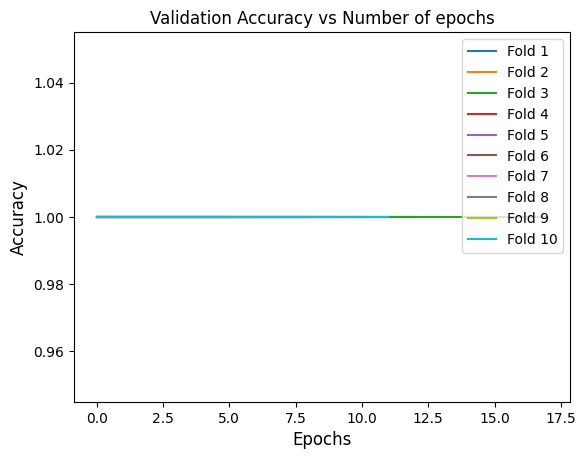

In [11]:

# Plot accuray history
for i in range(len(training_history_v1)):
    plt.plot(training_history_v1[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()


#### Plot the history of loss of training.

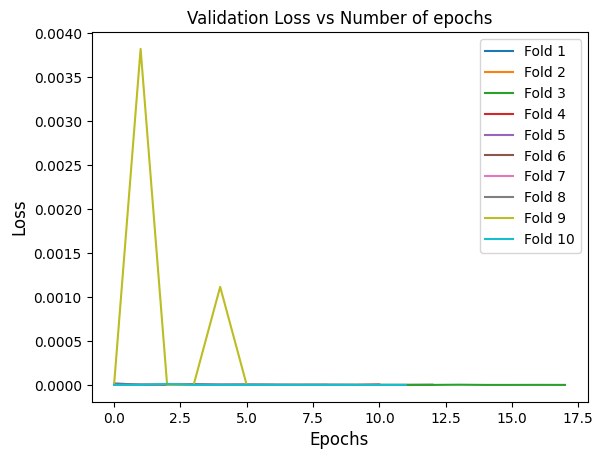

In [12]:

# Plot loss history
for i in range(len(training_history_v1)):
    plt.plot(training_history_v1[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Apply LIME technique to explain model predictions.


Generating upsampling through SMOTE...
200000 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(0): 6250, np.int64(1): 6250, np.int64(2): 6250, np.int64(3): 6250, np.int64(4): 6250, np.int64(5): 6250, np.int64(6): 6250, np.int64(7): 6250, np.int64(8): 6250, np.int64(9): 6250, np.int64(10): 6250, np.int64(11): 6250, np.int64(12): 6250, np.int64(13): 6250, np.int64(14): 6250, np.int64(15): 6250, np.int64(16): 6250, np.int64(17): 6250, np.int64(18): 6250, np.int64(19): 6250, np.int64(20): 6250, np.int64(21): 6250, np.int64(22): 6250, np.int64(23): 6250, np.int64(24): 6250, np.int64(25): 6250, np.int64(26): 6250, np.int64(27): 6250, np.int64(28): 6250, np.int64(29): 6250, np.int64(30): 6250, np.int64(31): 6250})
Finishing upsampling.

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Explain prediction for class 0:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 0 prediction:

Feature 490 - Contribution value: 0.0240307745

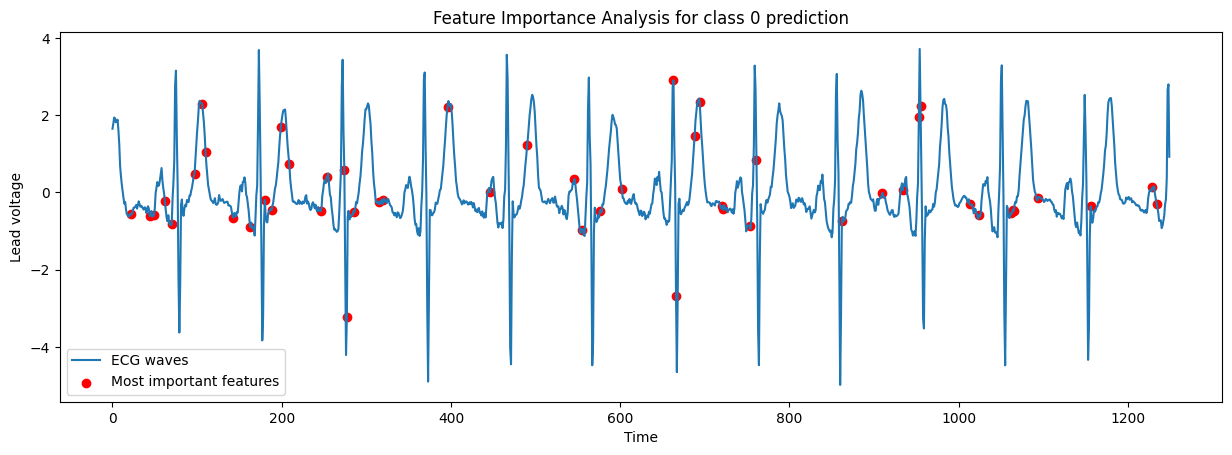


Explain prediction for class 1:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 1 prediction:

Feature 145 - Contribution value: 0.016467254208278412
Feature 667 - Contribution value: 0.014366225791184921
Feature 1013 - Contribution value: 0.014231700053990118
Feature 68 - Contribution value: 0.013980802059985191
Feature 848 - Contribution value: 0.013066370403827117
Feature 436 - Contribution value: 0.01305125244361445
Feature 234 - Contribution value: 0.013050483396828
Feature 934 - Contribution value: 0.013031112919935068
Feature 1194 - Contribution value: 0.013028601559980469
Feature 164 - Contribution value: 0.012805482629913035
Feature 920 - Contribution value: 0.01252535870906137
Feature 297 - Contribution value: 0.012495058785099359
Feature 501 - Contribution value: 0.012494681378668352
Feature 19 - Contribution value: 0.01203821672959128
Feature 1207 - Contribution value: 0.011974389552302395
Feature 975 - Contribution value: 0.011852316771630

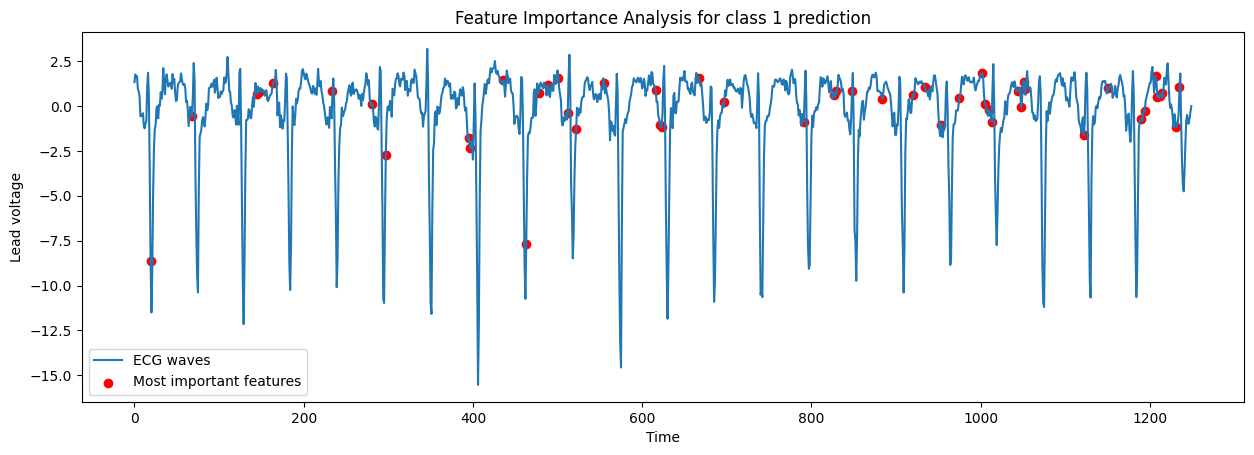


Explain prediction for class 2:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 2 prediction:

Feature 128 - Contribution value: 0.01864840843387564
Feature 143 - Contribution value: 0.018522553057176212
Feature 621 - Contribution value: 0.018519166851774255
Feature 278 - Contribution value: 0.018280851151235566
Feature 1038 - Contribution value: 0.017135624297976857
Feature 6 - Contribution value: 0.016611811140721168
Feature 627 - Contribution value: 0.016326851396658244
Feature 897 - Contribution value: 0.01623322267819738
Feature 320 - Contribution value: 0.015282956567024657
Feature 286 - Contribution value: 0.015212156806137791
Feature 490 - Contribution value: 0.015136062607220727
Feature 443 - Contribution value: 0.01471507594323836
Feature 1179 - Contribution value: 0.014621803627889597
Feature 501 - Contribution value: 0.014519787099799036
Feature 955 - Contribution value: 0.014273675083825361
Feature 960 - Contribution value: 0.0142225901486

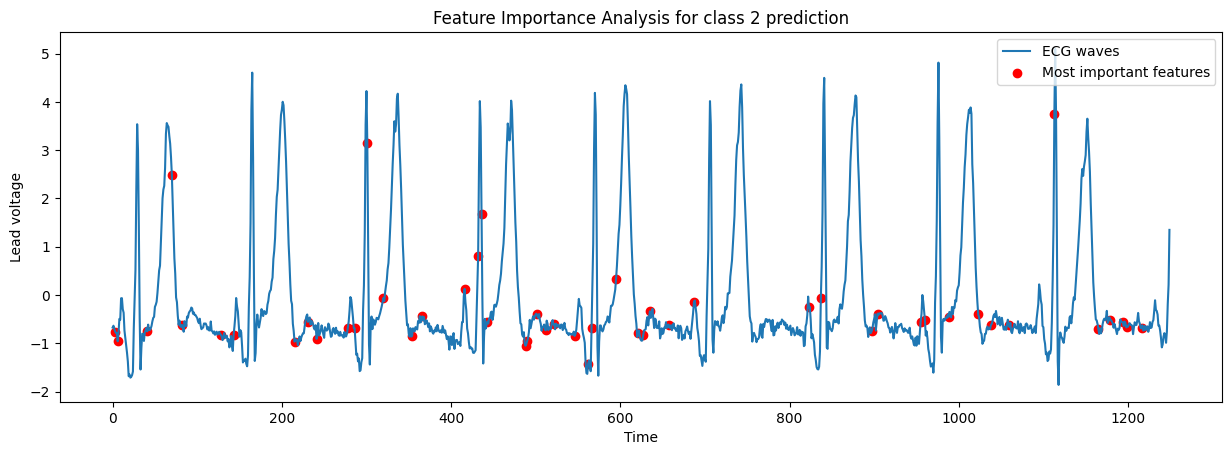


Explain prediction for class 3:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 3 prediction:

Feature 581 - Contribution value: 0.021323505097132187
Feature 461 - Contribution value: 0.019287811054748923
Feature 590 - Contribution value: 0.018833195245360236
Feature 384 - Contribution value: 0.01837149832501327
Feature 758 - Contribution value: 0.017665546967843556
Feature 567 - Contribution value: 0.017009352399980762
Feature 1064 - Contribution value: 0.01665315223266945
Feature 427 - Contribution value: 0.016622705054458405
Feature 1204 - Contribution value: 0.01630179820076309
Feature 1024 - Contribution value: 0.016098835754571245
Feature 70 - Contribution value: 0.01592221360183465
Feature 598 - Contribution value: 0.015739730090218174
Feature 1217 - Contribution value: 0.015365161279557242
Feature 711 - Contribution value: 0.014865793207019858
Feature 1052 - Contribution value: 0.014845746788466159
Feature 233 - Contribution value: 0.0148360264

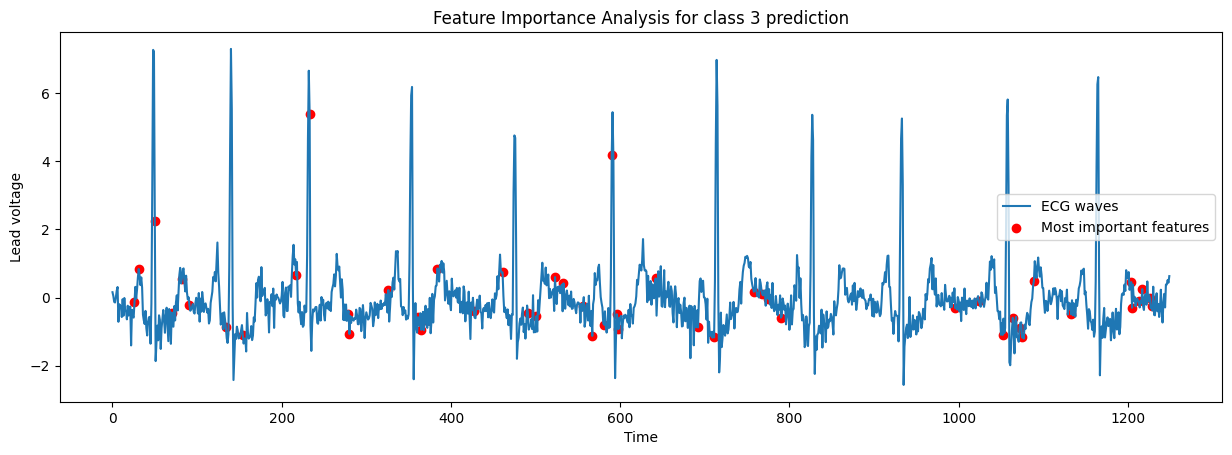


Explain prediction for class 4:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 4 prediction:

Feature 1150 - Contribution value: 0.019490635408028163
Feature 721 - Contribution value: 0.018198745461215467
Feature 529 - Contribution value: 0.01778150809388739
Feature 522 - Contribution value: 0.017180531485726607
Feature 781 - Contribution value: 0.016943738120151715
Feature 1085 - Contribution value: 0.016643629591260124
Feature 862 - Contribution value: 0.016530650919985176
Feature 1220 - Contribution value: 0.01635782659288205
Feature 98 - Contribution value: 0.01627699753009569
Feature 16 - Contribution value: 0.01616196666557268
Feature 930 - Contribution value: 0.016079797041616793
Feature 69 - Contribution value: 0.0160754071715255
Feature 1018 - Contribution value: 0.015893735798658912
Feature 1181 - Contribution value: 0.015812975134301334
Feature 68 - Contribution value: 0.01571235766323446
Feature 974 - Contribution value: 0.0157037186405311

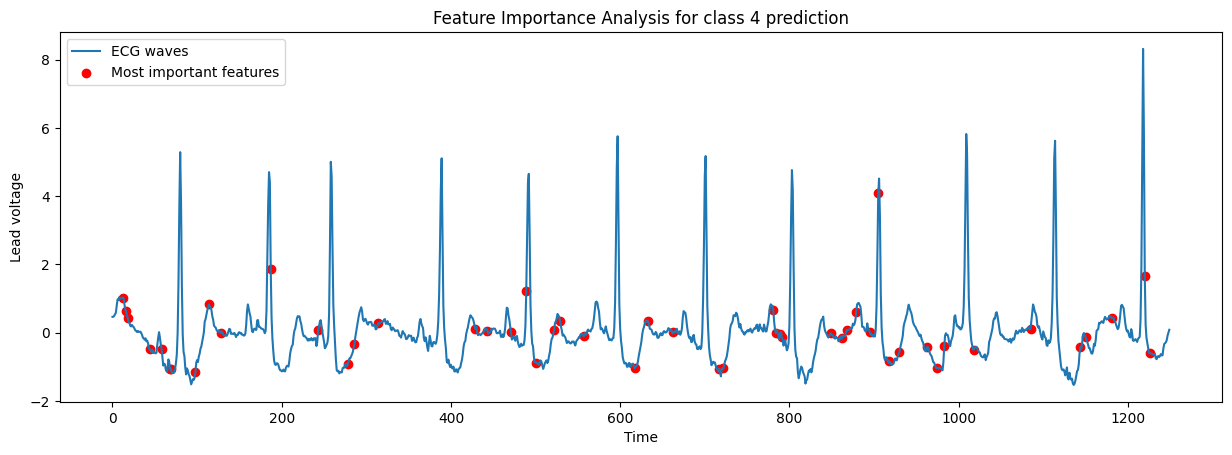


Explain prediction for class 5:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 5 prediction:

Feature 796 - Contribution value: 0.021367281230537355
Feature 411 - Contribution value: 0.020131824883267042
Feature 988 - Contribution value: 0.018993453676128463
Feature 235 - Contribution value: 0.017404591340907265
Feature 853 - Contribution value: 0.01708166531088449
Feature 755 - Contribution value: 0.016882893400581658
Feature 943 - Contribution value: 0.016336653849294433
Feature 804 - Contribution value: 0.01621514610671948
Feature 1139 - Contribution value: 0.01584988694435175
Feature 758 - Contribution value: 0.015762646762654948
Feature 862 - Contribution value: 0.01538475990020981
Feature 349 - Contribution value: 0.015230204438989887
Feature 218 - Contribution value: 0.015099314376828963
Feature 402 - Contribution value: 0.014990937098522178
Feature 154 - Contribution value: 0.014867228986986114
Feature 686 - Contribution value: 0.0146262084093

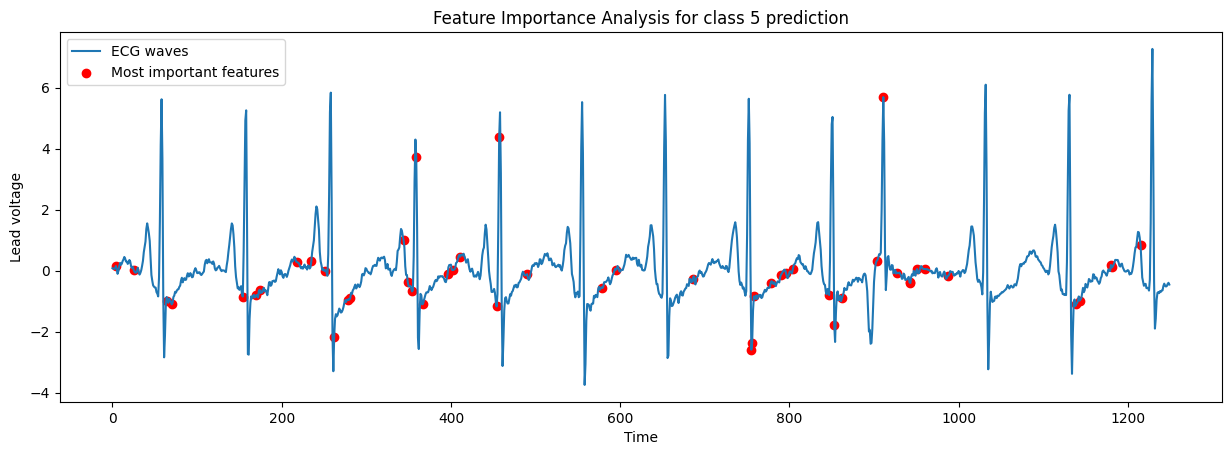


Explain prediction for class 6:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 6 prediction:

Feature 70 - Contribution value: 0.02108821230466771
Feature 781 - Contribution value: 0.017933023123083355
Feature 314 - Contribution value: 0.017574367988226876
Feature 480 - Contribution value: 0.017521324605304815
Feature 983 - Contribution value: 0.01740244693864781
Feature 951 - Contribution value: 0.017070755838871944
Feature 327 - Contribution value: 0.016987993667097304
Feature 208 - Contribution value: 0.016817886386957834
Feature 65 - Contribution value: 0.01655047820114687
Feature 1038 - Contribution value: 0.016548773844754006
Feature 82 - Contribution value: 0.01652343683521864
Feature 801 - Contribution value: 0.01627366068749977
Feature 234 - Contribution value: 0.016028023015336963
Feature 960 - Contribution value: 0.015634118908183045
Feature 555 - Contribution value: 0.015509603121582395
Feature 256 - Contribution value: 0.01538891192737912

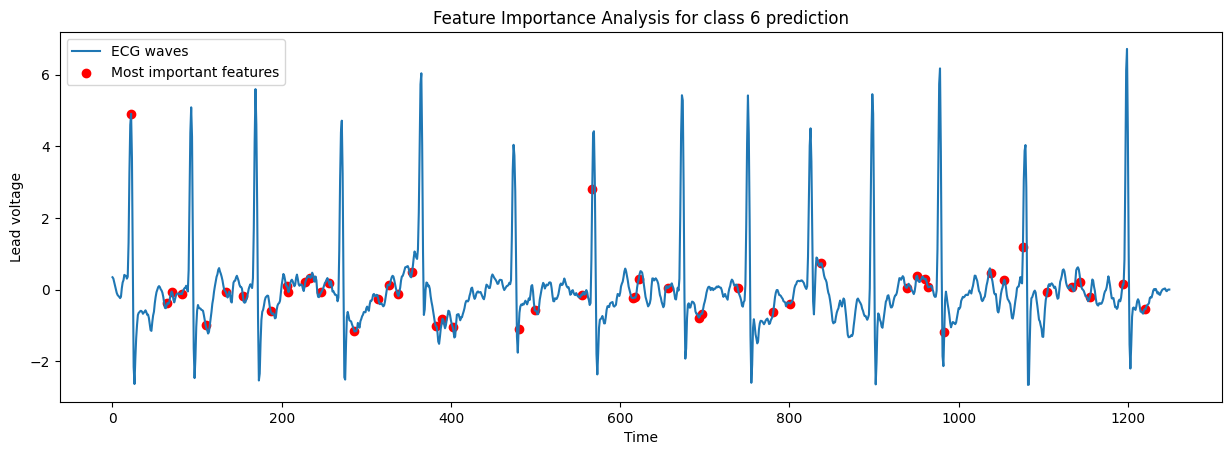


Explain prediction for class 7:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 7 prediction:

Feature 1149 - Contribution value: 0.02547091278320847
Feature 227 - Contribution value: 0.022852426979165626
Feature 955 - Contribution value: 0.021269136662193024
Feature 1165 - Contribution value: 0.02018799493299505
Feature 421 - Contribution value: 0.019229970237133638
Feature 449 - Contribution value: 0.019065930821654507
Feature 145 - Contribution value: 0.018726418864970354
Feature 367 - Contribution value: 0.018396270513114876
Feature 354 - Contribution value: 0.017691041066736822
Feature 35 - Contribution value: 0.017581656627240663
Feature 98 - Contribution value: 0.017265946512106542
Feature 1004 - Contribution value: 0.016809823961540817
Feature 185 - Contribution value: 0.016647361009811436
Feature 427 - Contribution value: 0.016565333231415617
Feature 519 - Contribution value: 0.016531805974782713
Feature 154 - Contribution value: 0.01574975732

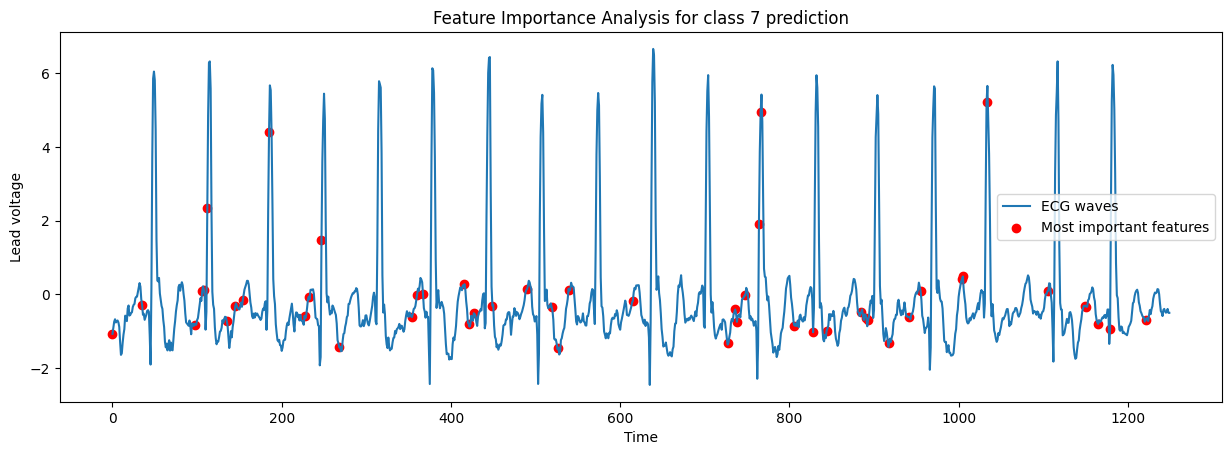


Explain prediction for class 8:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 8 prediction:

Feature 689 - Contribution value: 0.021080872304726345
Feature 1221 - Contribution value: 0.0202458712649715
Feature 1179 - Contribution value: 0.018527354469648073
Feature 488 - Contribution value: 0.017954686817525923
Feature 235 - Contribution value: 0.017446789005855983
Feature 375 - Contribution value: 0.016808372863295333
Feature 877 - Contribution value: 0.016602952378999388
Feature 1106 - Contribution value: 0.01618569973909761
Feature 918 - Contribution value: 0.01590664404898672
Feature 1010 - Contribution value: 0.015802412094419484
Feature 605 - Contribution value: 0.01573261271532083
Feature 1181 - Contribution value: 0.015454559335993257
Feature 958 - Contribution value: 0.015169333321365915
Feature 395 - Contribution value: 0.015115959593249385
Feature 366 - Contribution value: 0.014532048776258995
Feature 811 - Contribution value: 0.0144552588

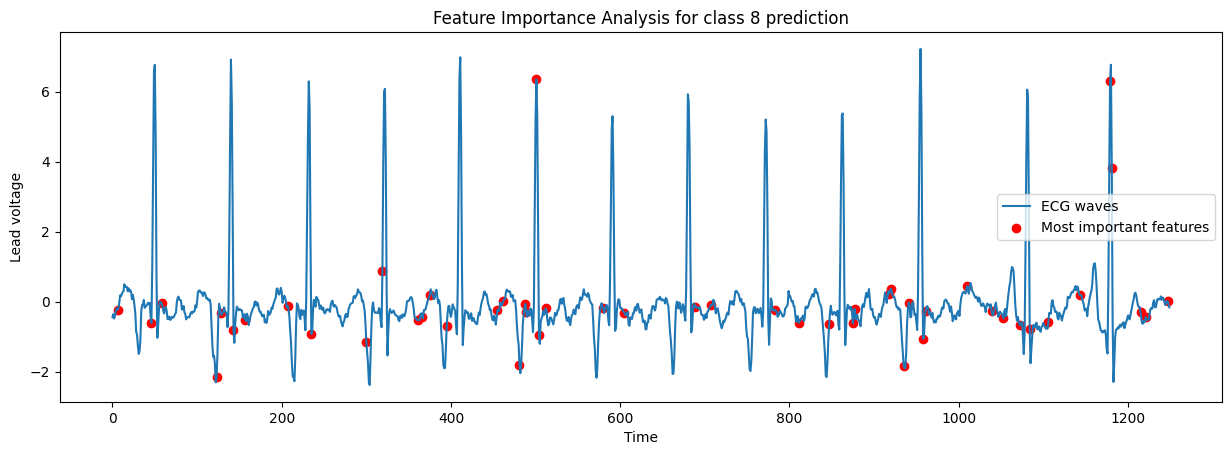


Explain prediction for class 9:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 9 prediction:

Feature 370 - Contribution value: 0.026032312268026495
Feature 729 - Contribution value: 0.020222398911131714
Feature 1107 - Contribution value: 0.01935200667070639
Feature 70 - Contribution value: 0.018919539966296042
Feature 521 - Contribution value: 0.0175443766908929
Feature 694 - Contribution value: 0.017350043505874442
Feature 736 - Contribution value: 0.016208678046399656
Feature 885 - Contribution value: 0.016009913135981275
Feature 16 - Contribution value: 0.015762155382184756
Feature 689 - Contribution value: 0.01567125847319102
Feature 279 - Contribution value: 0.01564267278150953
Feature 145 - Contribution value: 0.015629825307971957
Feature 88 - Contribution value: 0.015461754366331466
Feature 902 - Contribution value: 0.0153519691899429
Feature 1105 - Contribution value: 0.015294315675028642
Feature 617 - Contribution value: 0.014778047898729763

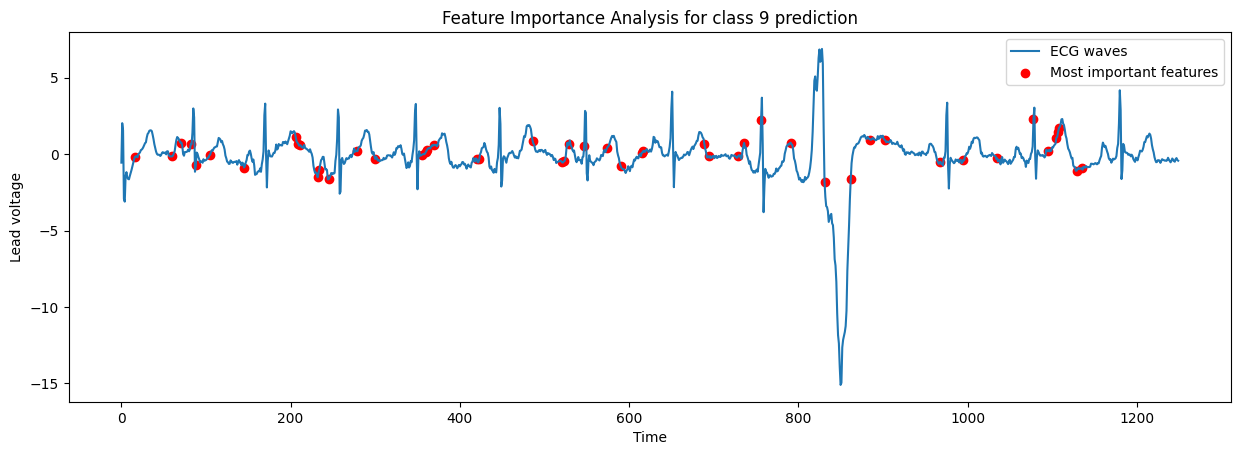


Explain prediction for class 10:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 10 prediction:

Feature 31 - Contribution value: 0.023467667977916506
Feature 1179 - Contribution value: 0.020020897710382728
Feature 19 - Contribution value: 0.019618717809929492
Feature 105 - Contribution value: 0.018369712200482488
Feature 355 - Contribution value: 0.01813708010389717
Feature 487 - Contribution value: 0.017761289857668738
Feature 893 - Contribution value: 0.01657385789873107
Feature 567 - Contribution value: 0.016283332560244137
Feature 1005 - Contribution value: 0.016245788340181644
Feature 70 - Contribution value: 0.01606231174334565
Feature 500 - Contribution value: 0.015977580017513402
Feature 175 - Contribution value: 0.015052602866484218
Feature 145 - Contribution value: 0.015036187002166529
Feature 1062 - Contribution value: 0.014921693996560131
Feature 306 - Contribution value: 0.01467739580147142
Feature 1063 - Contribution value: 0.01461806743

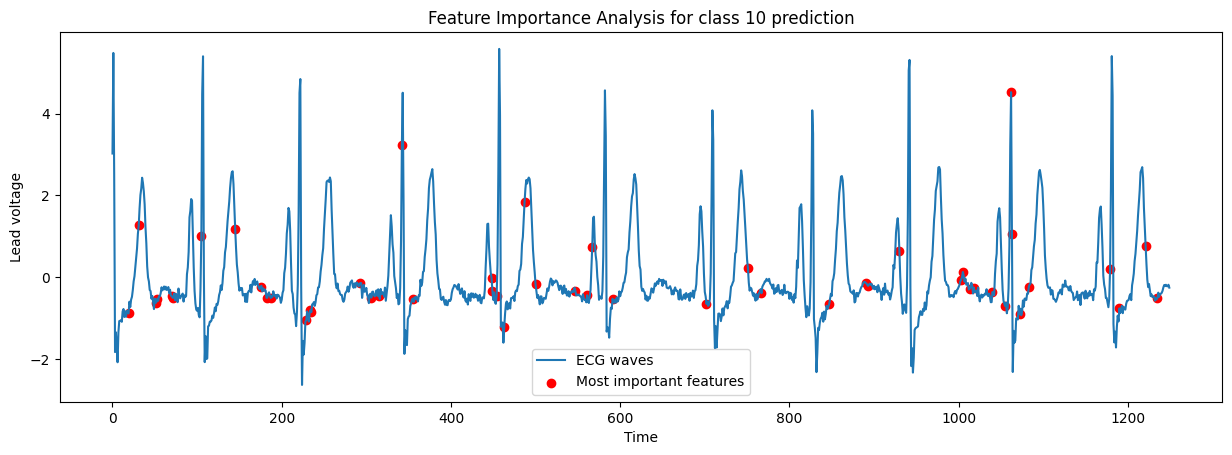


Explain prediction for class 11:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 11 prediction:

Feature 562 - Contribution value: 0.0244337231982317
Feature 622 - Contribution value: 0.01889283832352081
Feature 757 - Contribution value: 0.018801796321456243
Feature 220 - Contribution value: 0.017292423160033966
Feature 381 - Contribution value: 0.017220295910991435
Feature 88 - Contribution value: 0.016741786654497975
Feature 436 - Contribution value: 0.016628084161963205
Feature 35 - Contribution value: 0.016456854194749664
Feature 975 - Contribution value: 0.01600080270557224
Feature 862 - Contribution value: 0.015817408471136503
Feature 107 - Contribution value: 0.01578421832780393
Feature 1163 - Contribution value: 0.015458730287264084
Feature 708 - Contribution value: 0.015351828426778213
Feature 77 - Contribution value: 0.015328053505720482
Feature 235 - Contribution value: 0.0153216640787713
Feature 598 - Contribution value: 0.01484431085404775

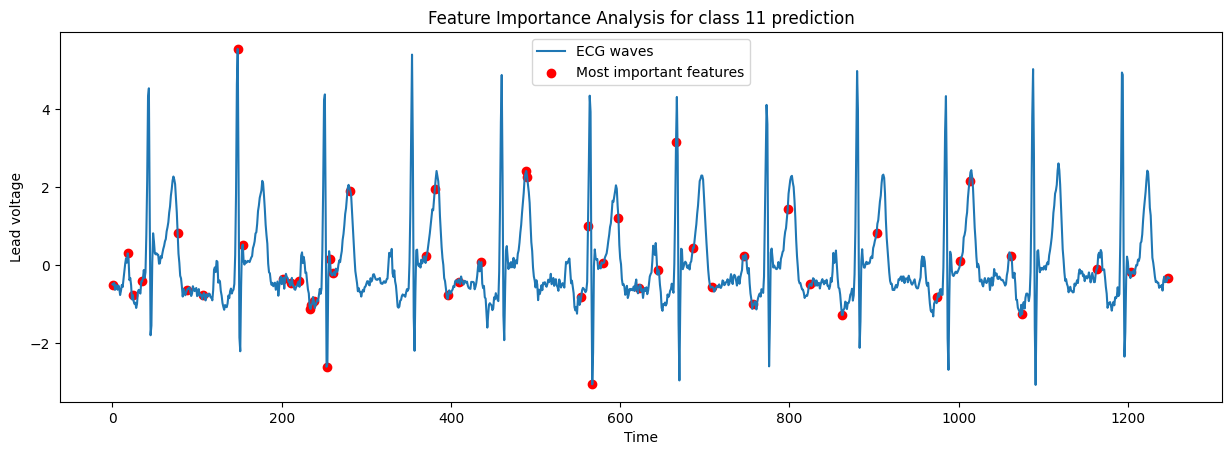


Explain prediction for class 12:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 12 prediction:

Feature 565 - Contribution value: 0.026283538912458534
Feature 186 - Contribution value: 0.02179352068033765
Feature 70 - Contribution value: 0.01982740939308041
Feature 75 - Contribution value: 0.019107004849097102
Feature 975 - Contribution value: 0.018697209306329888
Feature 370 - Contribution value: 0.0167741720127232
Feature 490 - Contribution value: 0.016772757223328612
Feature 202 - Contribution value: 0.01656075403851163
Feature 903 - Contribution value: 0.016498779463748413
Feature 1112 - Contribution value: 0.016458306354051308
Feature 911 - Contribution value: 0.01642010456039596
Feature 934 - Contribution value: 0.01628720667473961
Feature 447 - Contribution value: 0.01609555645842708
Feature 862 - Contribution value: 0.016013191227308907
Feature 379 - Contribution value: 0.015694421406923585
Feature 790 - Contribution value: 0.01562185118701030

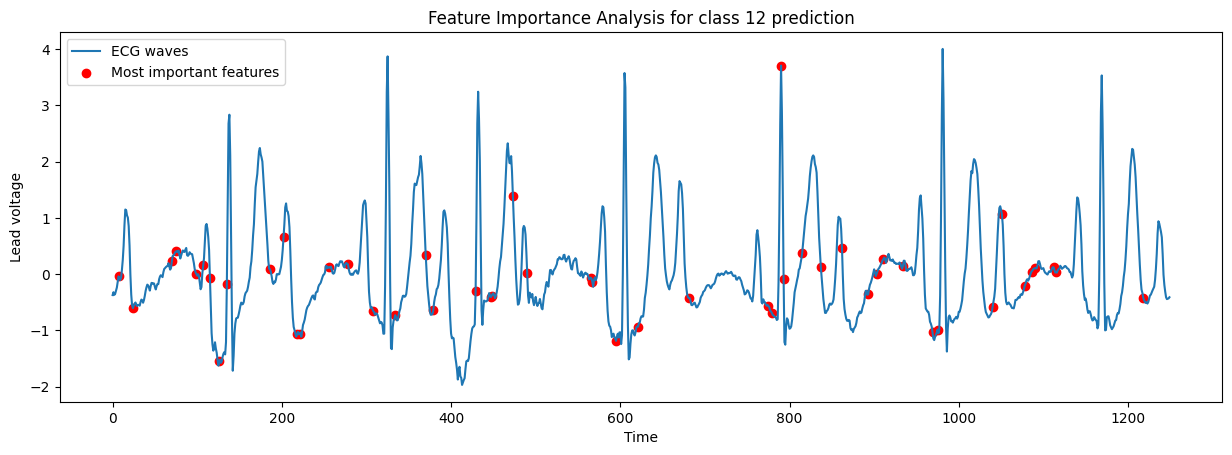


Explain prediction for class 13:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 13 prediction:

Feature 318 - Contribution value: 0.000553582883322571
Feature 779 - Contribution value: 0.0005252575968415079
Feature 1126 - Contribution value: 0.00047201848406559977
Feature 780 - Contribution value: 0.00046503360641465564
Feature 433 - Contribution value: 0.0004467867337560336
Feature 88 - Contribution value: 0.0004297212594584359
Feature 781 - Contribution value: 0.00041181163838147533
Feature 664 - Contribution value: 0.0004082950811804881
Feature 1125 - Contribution value: 0.000392888959364069
Feature 547 - Contribution value: 0.0003872614041629758
Feature 434 - Contribution value: 0.00038091422754364315
Feature 436 - Contribution value: 0.000375576978011888
Feature 432 - Contribution value: 0.00037247240050225294
Feature 202 - Contribution value: 0.00036374319999644066
Feature 549 - Contribution value: 0.0003616419861206824
Feature 1009 - Contributi

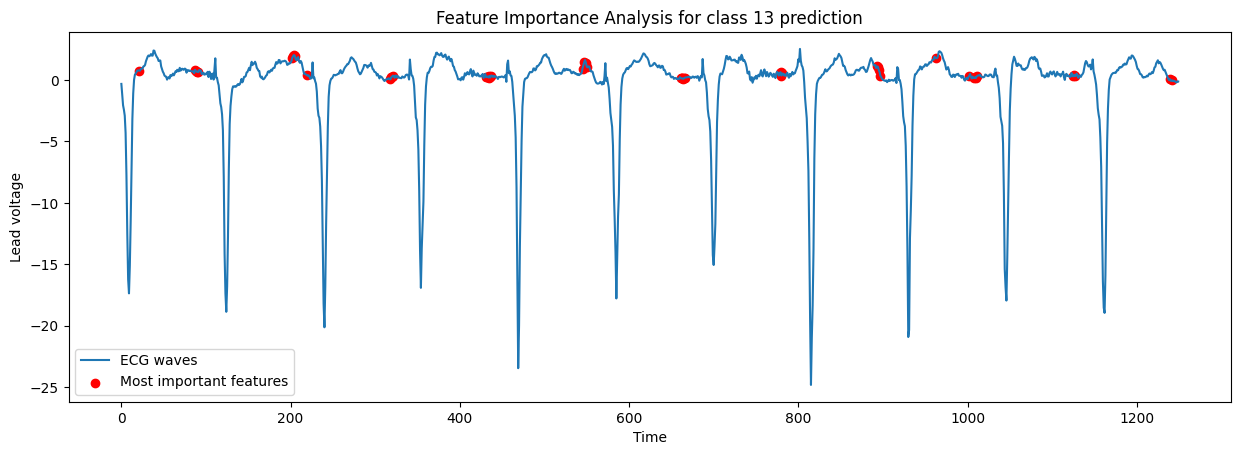


Explain prediction for class 14:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 14 prediction:

Feature 335 - Contribution value: 0.0092835166954321
Feature 492 - Contribution value: 0.008923817014330818
Feature 83 - Contribution value: 0.008920814193167283
Feature 953 - Contribution value: 0.008877755523801779
Feature 636 - Contribution value: 0.00869768934327187
Feature 649 - Contribution value: 0.008096080604997833
Feature 293 - Contribution value: 0.007945430973604607
Feature 896 - Contribution value: 0.00763082059874936
Feature 689 - Contribution value: 0.007525174432137844
Feature 989 - Contribution value: 0.00737970446467014
Feature 1037 - Contribution value: 0.00732532348905962
Feature 88 - Contribution value: 0.007238904613896908
Feature 426 - Contribution value: 0.0072299071121718645
Feature 251 - Contribution value: 0.007203747335536777
Feature 70 - Contribution value: 0.007083451108759957
Feature 170 - Contribution value: 0.006977116472703

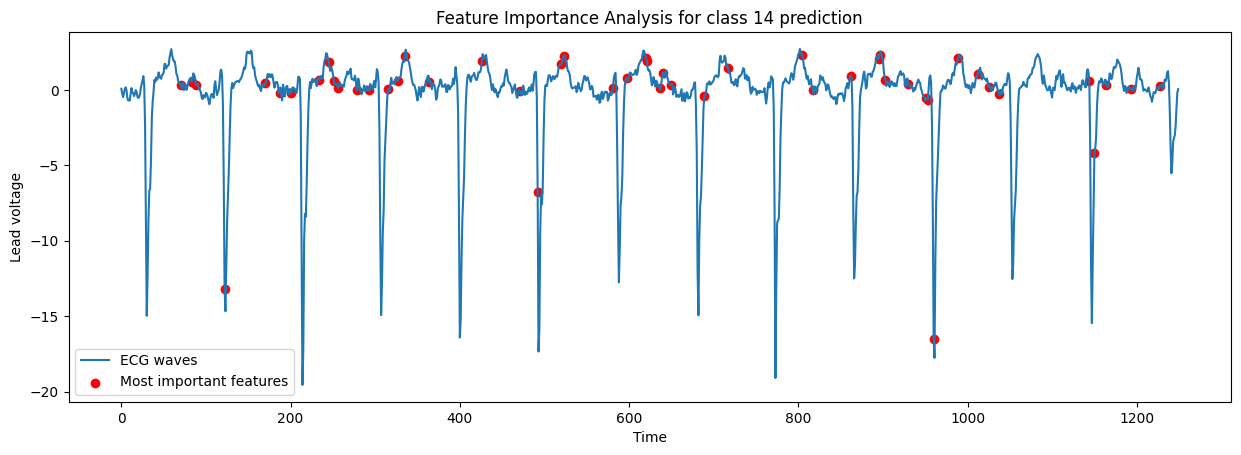


Explain prediction for class 15:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 15 prediction:

Feature 889 - Contribution value: 6.309468267652934e-109
Feature 890 - Contribution value: 4.440186515746169e-109
Feature 888 - Contribution value: 4.277078526414869e-109
Feature 186 - Contribution value: 2.9456206340098696e-109
Feature 185 - Contribution value: 2.9436324065659452e-109
Feature 891 - Contribution value: 2.9238207511843262e-109
Feature 187 - Contribution value: 2.8122138626243213e-109
Feature 728 - Contribution value: 2.581164731836518e-109
Feature 727 - Contribution value: 2.167693046427513e-109
Feature 726 - Contribution value: 2.1145941295365222e-109
Feature 188 - Contribution value: 2.086657949066321e-109
Feature 887 - Contribution value: 1.8163816464414398e-109
Feature 892 - Contribution value: 1.7842620460901075e-109
Feature 184 - Contribution value: 1.6262411082272629e-109
Feature 725 - Contribution value: 1.483741828557409e-109
Featur

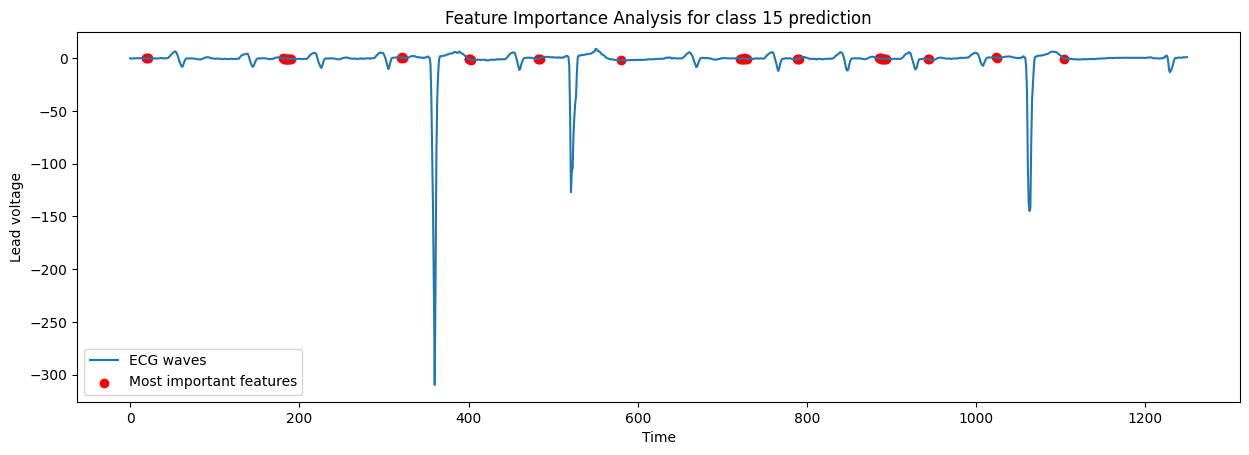


Explain prediction for class 16:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 16 prediction:

Feature 377 - Contribution value: 0.020069742855223324
Feature 278 - Contribution value: 0.020002226809792342
Feature 953 - Contribution value: 0.017774267820615634
Feature 382 - Contribution value: 0.017323158330708636
Feature 944 - Contribution value: 0.01693616715919756
Feature 44 - Contribution value: 0.016441198396656767
Feature 951 - Contribution value: 0.016431578627888035
Feature 686 - Contribution value: 0.016406435687542707
Feature 396 - Contribution value: 0.016345113574476797
Feature 108 - Contribution value: 0.016315929434193414
Feature 701 - Contribution value: 0.016230262691405522
Feature 921 - Contribution value: 0.01588436716948218
Feature 309 - Contribution value: 0.015870053547612815
Feature 645 - Contribution value: 0.015525020257550886
Feature 49 - Contribution value: 0.015500944300946576
Feature 790 - Contribution value: 0.015358108519

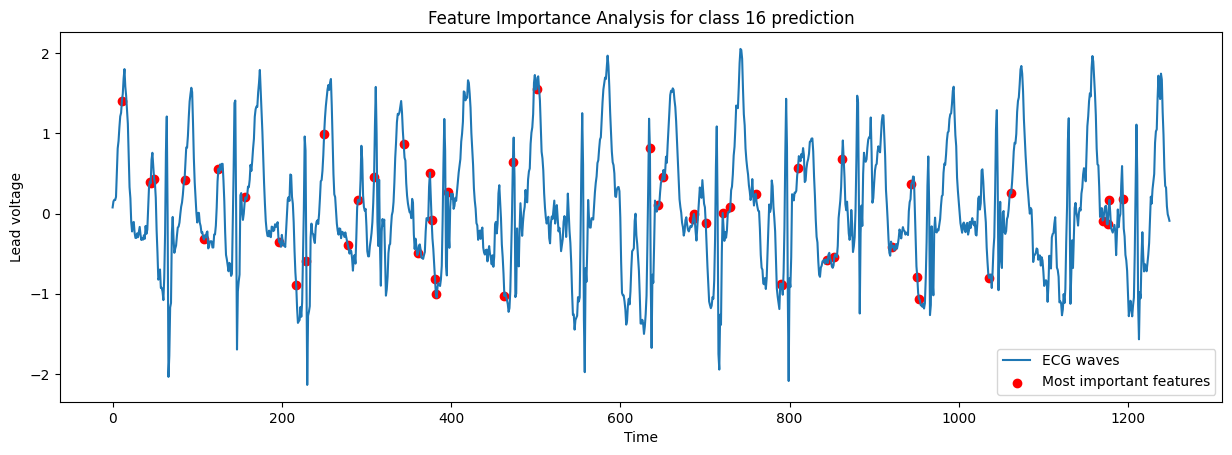


Explain prediction for class 17:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 17 prediction:

Feature 427 - Contribution value: 0.002006026754679427
Feature 804 - Contribution value: 0.0013045249747365758
Feature 708 - Contribution value: 0.0012936199482289905
Feature 281 - Contribution value: 0.0012635183482311995
Feature 512 - Contribution value: 0.0012498484269910508
Feature 370 - Contribution value: 0.001228459740065711
Feature 941 - Contribution value: 0.001224006760585497
Feature 246 - Contribution value: 0.0012041688474035187
Feature 590 - Contribution value: 0.001202272606349116
Feature 461 - Contribution value: 0.0011940255250299414
Feature 694 - Contribution value: 0.0011918341275186032
Feature 639 - Contribution value: 0.00111597424595481
Feature 448 - Contribution value: 0.001106710188701918
Feature 360 - Contribution value: 0.0010861282052425732
Feature 1026 - Contribution value: 0.0010757207481523082
Feature 177 - Contribution value: 0

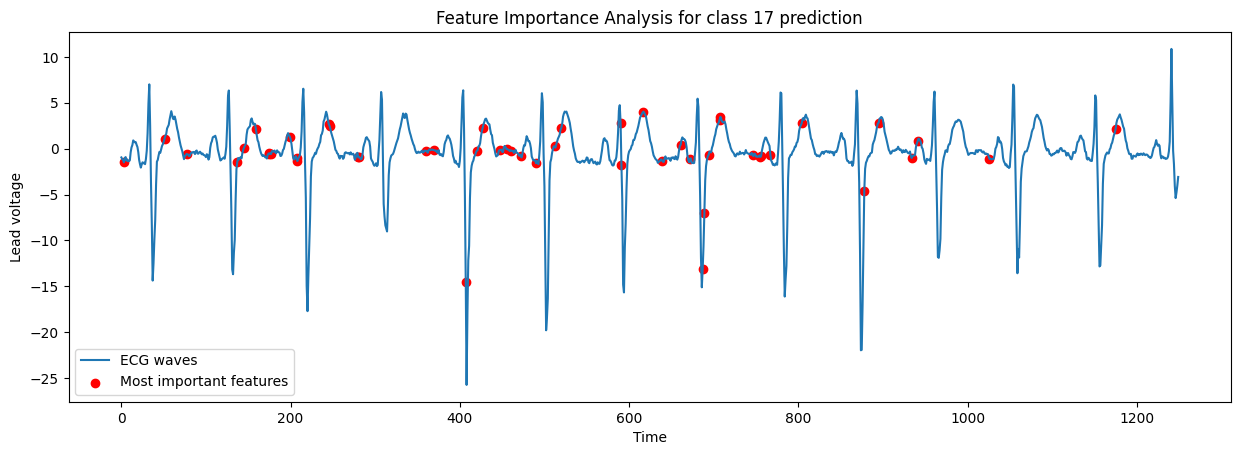


Explain prediction for class 18:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 18 prediction:

Feature 1094 - Contribution value: 0.019666953503390296
Feature 532 - Contribution value: 0.019278628391773533
Feature 191 - Contribution value: 0.01899204448489844
Feature 1221 - Contribution value: 0.01772192150420021
Feature 279 - Contribution value: 0.017578508082482958
Feature 1165 - Contribution value: 0.01640597766551904
Feature 1178 - Contribution value: 0.016245788781945384
Feature 862 - Contribution value: 0.01605608307319588
Feature 838 - Contribution value: 0.014641648107100856
Feature 689 - Contribution value: 0.014429641284998755
Feature 815 - Contribution value: 0.014140153773830514
Feature 490 - Contribution value: 0.014119452871512764
Feature 1078 - Contribution value: 0.013897477032640826
Feature 1112 - Contribution value: 0.013851400863353203
Feature 19 - Contribution value: 0.01371540112399842
Feature 70 - Contribution value: 0.013609855

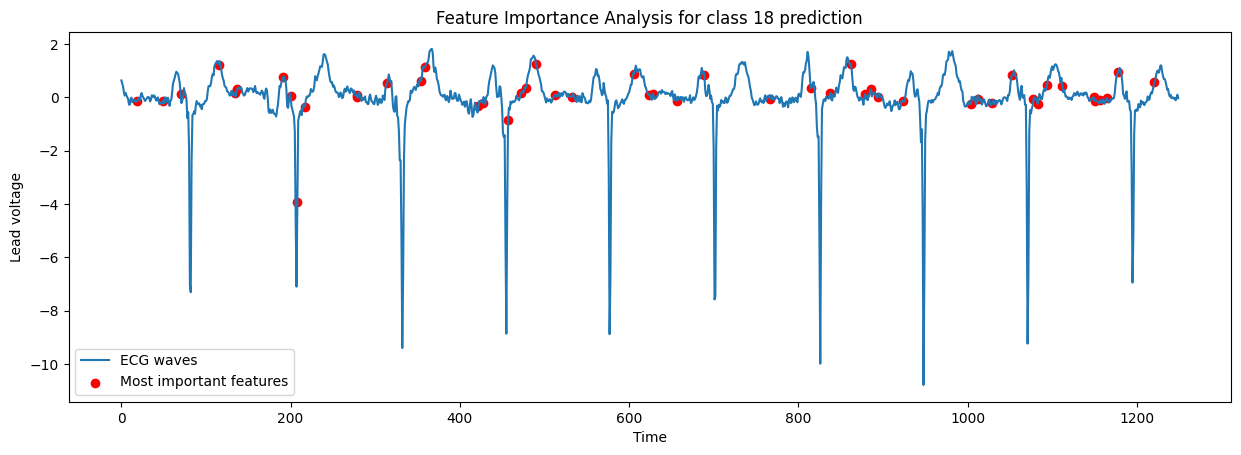


Explain prediction for class 19:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 19 prediction:

Feature 1115 - Contribution value: 0.023511745276836162
Feature 396 - Contribution value: 0.022943411645350048
Feature 99 - Contribution value: 0.021989907542236686
Feature 70 - Contribution value: 0.02110174679450563
Feature 1129 - Contribution value: 0.018433253586017308
Feature 245 - Contribution value: 0.01707129029347778
Feature 142 - Contribution value: 0.01704125372663535
Feature 489 - Contribution value: 0.01602815428651238
Feature 591 - Contribution value: 0.015569649931747278
Feature 1100 - Contribution value: 0.015499873401915597
Feature 454 - Contribution value: 0.015375095957679809
Feature 861 - Contribution value: 0.01533215333111283
Feature 85 - Contribution value: 0.01530207779883949
Feature 891 - Contribution value: 0.015159815508902146
Feature 934 - Contribution value: 0.015040607162536674
Feature 996 - Contribution value: 0.01501907693349

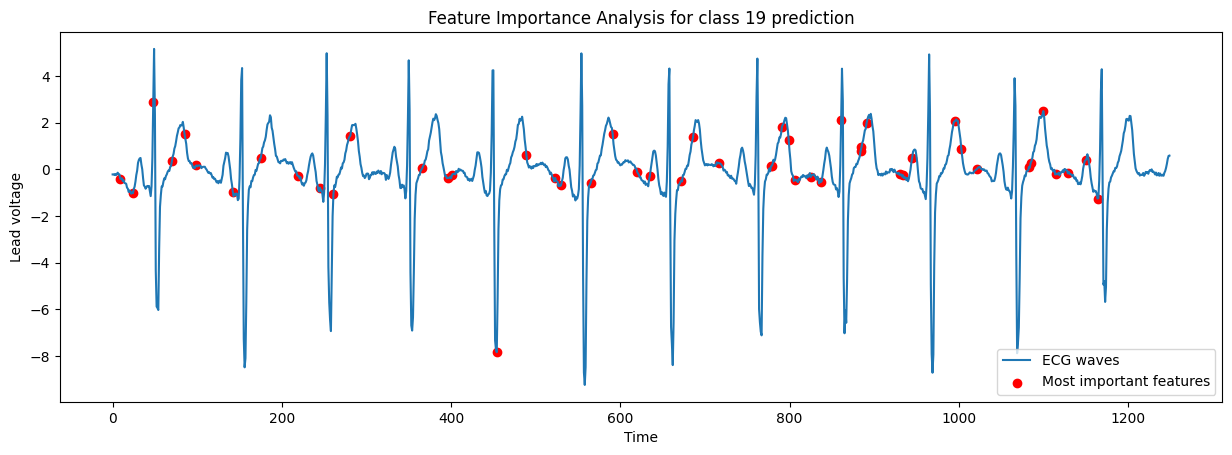


Explain prediction for class 20:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 20 prediction:

Feature 1165 - Contribution value: 0.0213496005346641
Feature 136 - Contribution value: 0.019414458769636565
Feature 73 - Contribution value: 0.01893517710820153
Feature 1205 - Contribution value: 0.018633091085716695
Feature 472 - Contribution value: 0.01808589109098081
Feature 851 - Contribution value: 0.016827067657921028
Feature 591 - Contribution value: 0.016349222268482802
Feature 286 - Contribution value: 0.015810897171165503
Feature 739 - Contribution value: 0.015527249499493946
Feature 920 - Contribution value: 0.015327846146690567
Feature 903 - Contribution value: 0.015317588492264505
Feature 240 - Contribution value: 0.015235213980205605
Feature 885 - Contribution value: 0.01512655350557026
Feature 766 - Contribution value: 0.014986314625697517
Feature 721 - Contribution value: 0.014828197874832817
Feature 952 - Contribution value: 0.014827979716

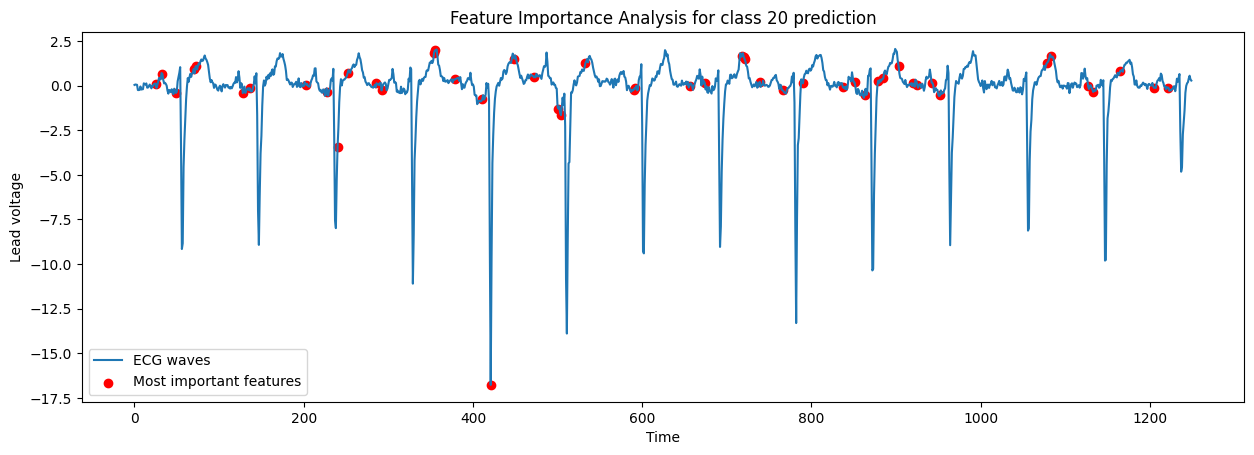


Explain prediction for class 21:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 21 prediction:

Feature 590 - Contribution value: 0.02107928097888743
Feature 608 - Contribution value: 0.018557001165155757
Feature 175 - Contribution value: 0.01753442486556213
Feature 60 - Contribution value: 0.017034576786369986
Feature 143 - Contribution value: 0.01686211756841986
Feature 778 - Contribution value: 0.016589780075321615
Feature 1085 - Contribution value: 0.016578610514292744
Feature 1038 - Contribution value: 0.016445215003705244
Feature 431 - Contribution value: 0.01635790308803302
Feature 272 - Contribution value: 0.01620222279568212
Feature 710 - Contribution value: 0.01620113762343641
Feature 314 - Contribution value: 0.015887112806290547
Feature 355 - Contribution value: 0.015711969992647137
Feature 739 - Contribution value: 0.01564481494849627
Feature 4 - Contribution value: 0.015425068994107194
Feature 1222 - Contribution value: 0.015416156275260

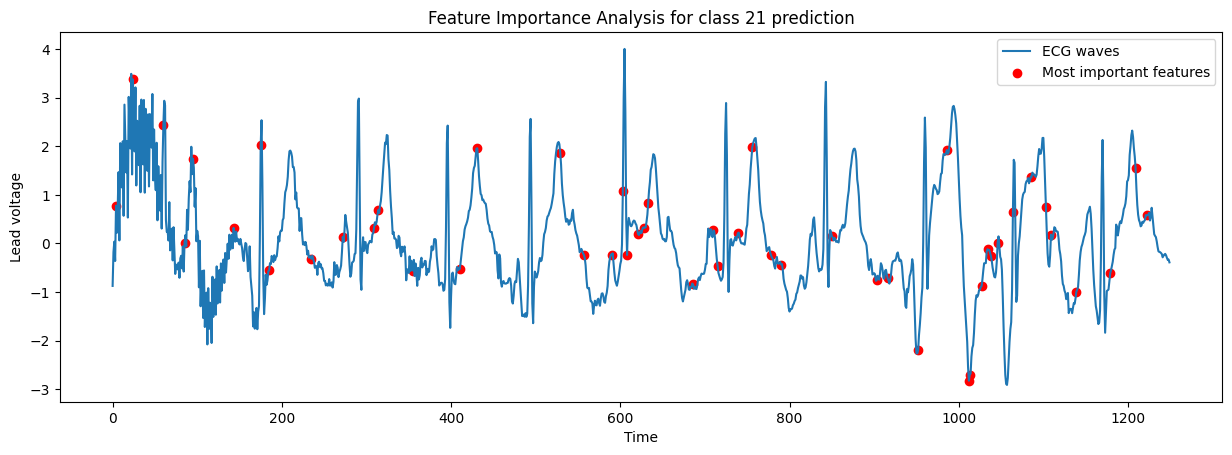


Explain prediction for class 22:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 22 prediction:

Feature 1156 - Contribution value: 0.02670035761539333
Feature 142 - Contribution value: 0.02018344735168236
Feature 850 - Contribution value: 0.019538636948565963
Feature 501 - Contribution value: 0.018828626639147715
Feature 686 - Contribution value: 0.0179111658756904
Feature 717 - Contribution value: 0.017527951200772367
Feature 207 - Contribution value: 0.016696753752777533
Feature 1129 - Contribution value: 0.015766197250609293
Feature 18 - Contribution value: 0.015735531097600373
Feature 278 - Contribution value: 0.015154082721028967
Feature 622 - Contribution value: 0.01503440326957577
Feature 1131 - Contribution value: 0.01493446897028714
Feature 784 - Contribution value: 0.014858650502107175
Feature 94 - Contribution value: 0.014837892164958934
Feature 953 - Contribution value: 0.014731296967592705
Feature 1179 - Contribution value: 0.014656850947

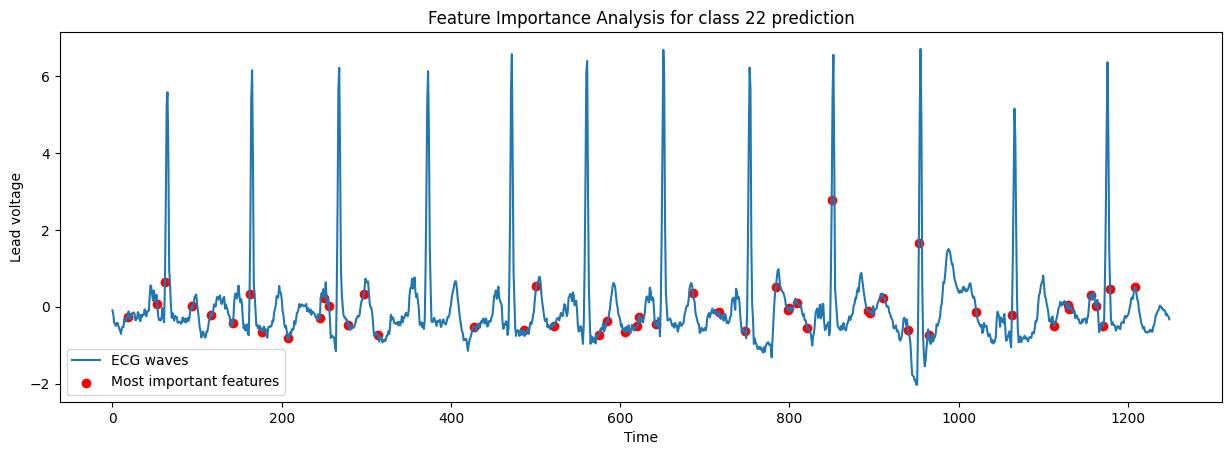


Explain prediction for class 23:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 23 prediction:

Feature 245 - Contribution value: 0.02285739128765876
Feature 633 - Contribution value: 0.01941572135450359
Feature 1129 - Contribution value: 0.01853204188477374
Feature 1115 - Contribution value: 0.01762056227352248
Feature 234 - Contribution value: 0.017234306244550898
Feature 385 - Contribution value: 0.01674240791580446
Feature 596 - Contribution value: 0.016667875393459985
Feature 256 - Contribution value: 0.01659866011345495
Feature 934 - Contribution value: 0.016457797811691963
Feature 94 - Contribution value: 0.016262802656362152
Feature 944 - Contribution value: 0.0157769436432321
Feature 1073 - Contribution value: 0.01566505830077884
Feature 1179 - Contribution value: 0.015494705663255063
Feature 736 - Contribution value: 0.015423157882610733
Feature 896 - Contribution value: 0.015357485087808759
Feature 929 - Contribution value: 0.01492967900595

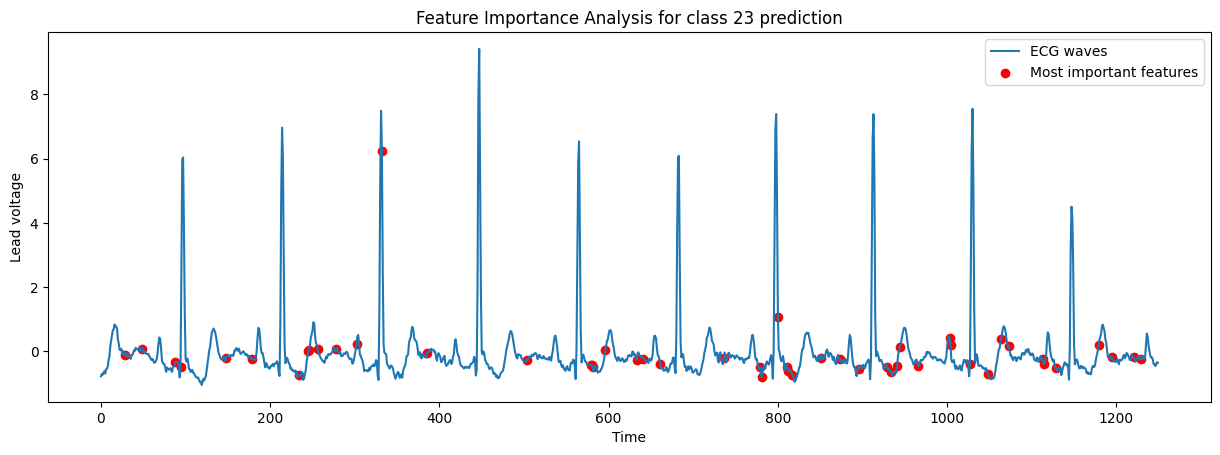


Explain prediction for class 24:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 24 prediction:

Feature 77 - Contribution value: 0.020902348887724024
Feature 31 - Contribution value: 0.019534808352676243
Feature 817 - Contribution value: 0.018352883365579338
Feature 804 - Contribution value: 0.01812381946459795
Feature 729 - Contribution value: 0.017742056945582813
Feature 654 - Contribution value: 0.017393189933697185
Feature 334 - Contribution value: 0.017271243421816542
Feature 208 - Contribution value: 0.016966450888859938
Feature 796 - Contribution value: 0.016833464113386588
Feature 49 - Contribution value: 0.01647328064844678
Feature 427 - Contribution value: 0.016472366040536646
Feature 145 - Contribution value: 0.01622645986129333
Feature 792 - Contribution value: 0.016204512390415763
Feature 649 - Contribution value: 0.016087104563529124
Feature 44 - Contribution value: 0.015905454426803793
Feature 136 - Contribution value: 0.015730684602444

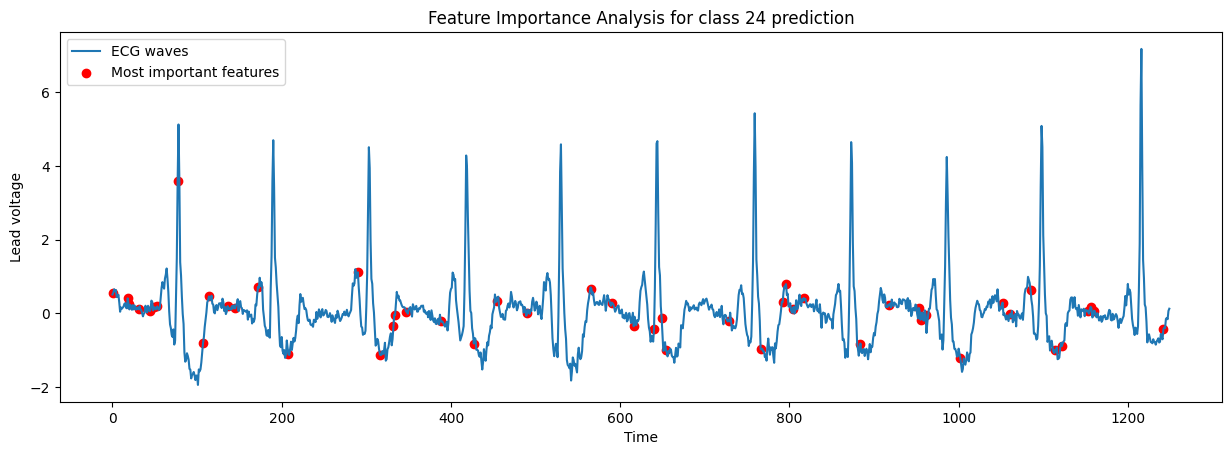


Explain prediction for class 25:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 25 prediction:

Feature 657 - Contribution value: 0.022080541757461127
Feature 990 - Contribution value: 0.019693480931835095
Feature 1018 - Contribution value: 0.017126930467161464
Feature 964 - Contribution value: 0.016357430637730562
Feature 1021 - Contribution value: 0.016148559875625138
Feature 554 - Contribution value: 0.016035084326114817
Feature 116 - Contribution value: 0.015603331165173963
Feature 1150 - Contribution value: 0.015346158881710191
Feature 608 - Contribution value: 0.015210336982259383
Feature 506 - Contribution value: 0.014825054732066661
Feature 923 - Contribution value: 0.014821594318397139
Feature 577 - Contribution value: 0.014623313065955735
Feature 1072 - Contribution value: 0.014590683681978335
Feature 117 - Contribution value: 0.014565255858799994
Feature 689 - Contribution value: 0.014496157768814594
Feature 1002 - Contribution value: 0.014

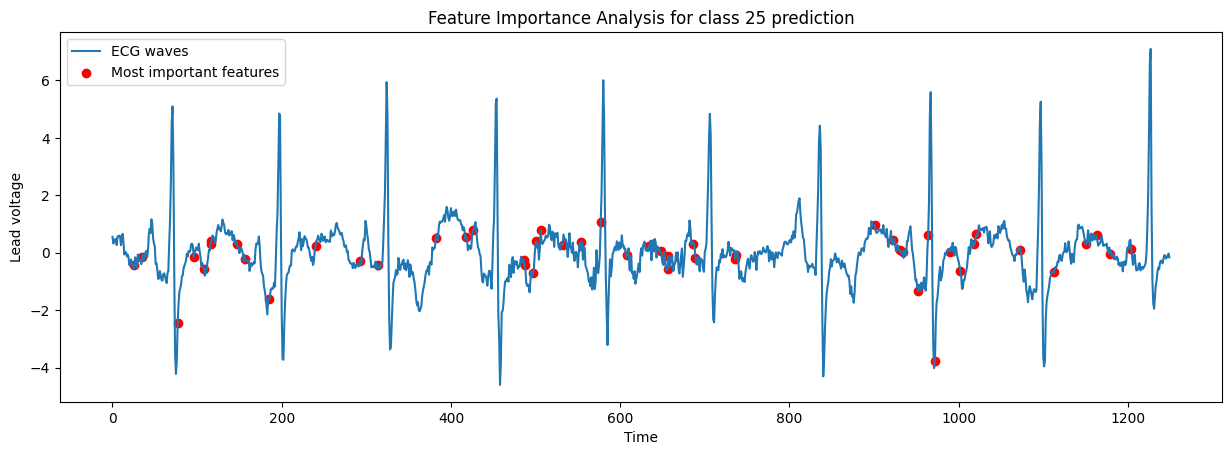


Explain prediction for class 26:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 26 prediction:

Feature 1204 - Contribution value: 0.020291416614781718
Feature 145 - Contribution value: 0.01996076448982145
Feature 472 - Contribution value: 0.019122002304822895
Feature 571 - Contribution value: 0.01870049583784437
Feature 1179 - Contribution value: 0.01847710995786361
Feature 1053 - Contribution value: 0.017816206443607846
Feature 1010 - Contribution value: 0.017632574103162425
Feature 70 - Contribution value: 0.017441732961137428
Feature 13 - Contribution value: 0.01716770283606799
Feature 191 - Contribution value: 0.017084825826760436
Feature 256 - Contribution value: 0.017048913777358232
Feature 390 - Contribution value: 0.016778028104668878
Feature 98 - Contribution value: 0.016692665105126153
Feature 427 - Contribution value: 0.016417294196119127
Feature 321 - Contribution value: 0.015854194605134098
Feature 528 - Contribution value: 0.01580961891

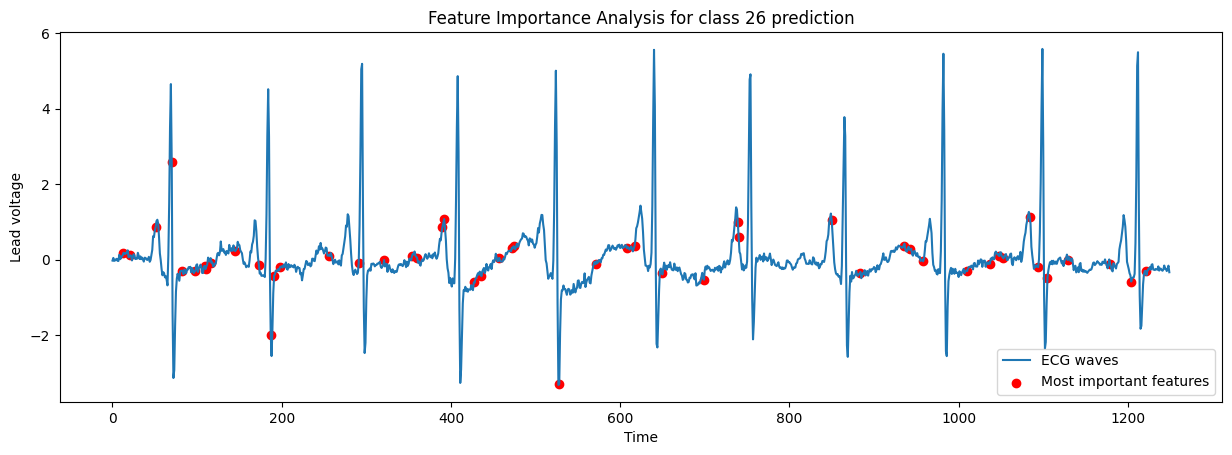


Explain prediction for class 27:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 27 prediction:

Feature 51 - Contribution value: 0.020376570998981276
Feature 686 - Contribution value: 0.018789162035312026
Feature 478 - Contribution value: 0.018181128510630414
Feature 591 - Contribution value: 0.017947006896615766
Feature 1084 - Contribution value: 0.017848876539354977
Feature 77 - Contribution value: 0.017695801556178194
Feature 806 - Contribution value: 0.017594421045397806
Feature 1129 - Contribution value: 0.01598258113943134
Feature 720 - Contribution value: 0.015195286518805777
Feature 1134 - Contribution value: 0.015153312322645678
Feature 1101 - Contribution value: 0.015024037600440026
Feature 831 - Contribution value: 0.014832602909550257
Feature 1157 - Contribution value: 0.014689904897287817
Feature 1217 - Contribution value: 0.014664578772053885
Feature 360 - Contribution value: 0.014555242863253003
Feature 1049 - Contribution value: 0.0145

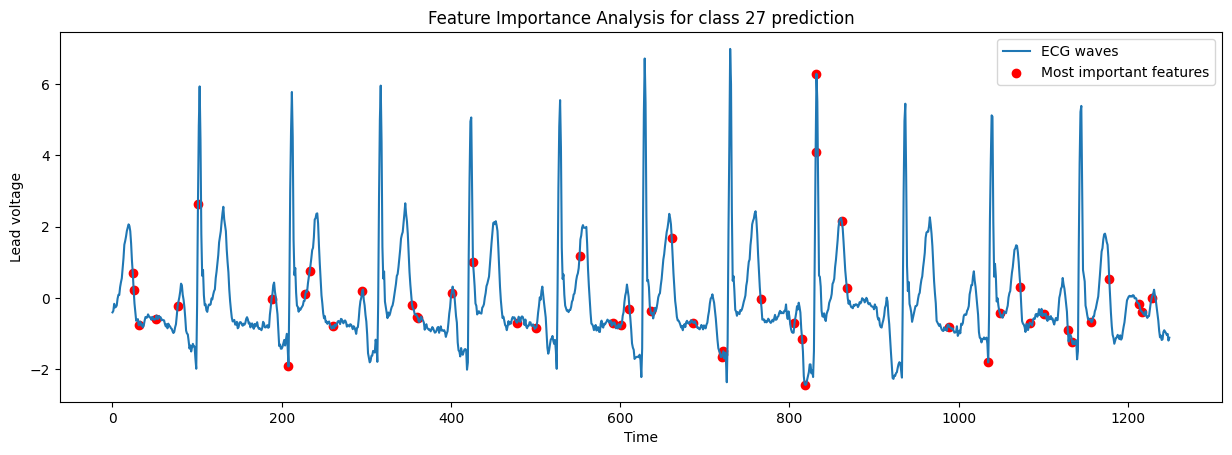


Explain prediction for class 28:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 28 prediction:

Feature 49 - Contribution value: 0.02251061203959842
Feature 891 - Contribution value: 0.021374078534609667
Feature 918 - Contribution value: 0.019682893324187673
Feature 187 - Contribution value: 0.017539417453234035
Feature 778 - Contribution value: 0.0168698923658963
Feature 68 - Contribution value: 0.016542921858654695
Feature 623 - Contribution value: 0.016521244691222584
Feature 951 - Contribution value: 0.015304828712204815
Feature 426 - Contribution value: 0.015215253451837621
Feature 803 - Contribution value: 0.015118451147631011
Feature 1056 - Contribution value: 0.015034949449835027
Feature 159 - Contribution value: 0.014936282560481325
Feature 354 - Contribution value: 0.014822999319761745
Feature 208 - Contribution value: 0.014721978754486937
Feature 1208 - Contribution value: 0.014663741459294902
Feature 863 - Contribution value: 0.01455756089

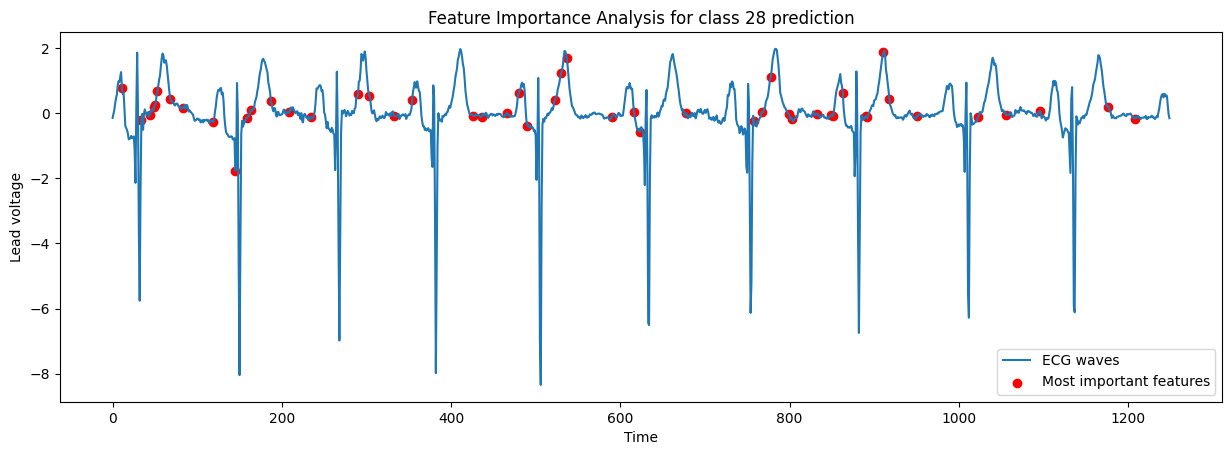


Explain prediction for class 29:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 29 prediction:

Feature 1072 - Contribution value: 0.020747855419678992
Feature 790 - Contribution value: 0.019564109303814362
Feature 689 - Contribution value: 0.019454977445129685
Feature 596 - Contribution value: 0.019205105463140037
Feature 247 - Contribution value: 0.019023792105570043
Feature 601 - Contribution value: 0.01831415710811561
Feature 791 - Contribution value: 0.01680975080616074
Feature 1112 - Contribution value: 0.016207635676078667
Feature 220 - Contribution value: 0.01614192719546813
Feature 953 - Contribution value: 0.01603664350344133
Feature 805 - Contribution value: 0.015813375690572794
Feature 862 - Contribution value: 0.015728497397289026
Feature 481 - Contribution value: 0.015484367216838282
Feature 352 - Contribution value: 0.015464651497983263
Feature 672 - Contribution value: 0.015364276588577315
Feature 796 - Contribution value: 0.0153236641

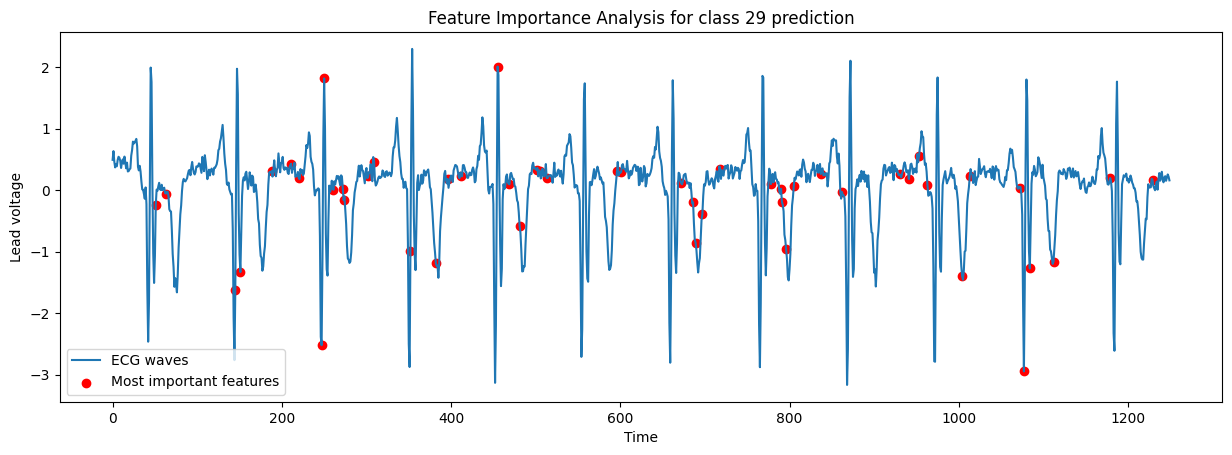


Explain prediction for class 30:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Top 30 feature contributions to class 30 prediction:

Feature 501 - Contribution value: 0.020506255905016833
Feature 490 - Contribution value: 0.018190807396736064
Feature 512 - Contribution value: 0.01765703975144708
Feature 557 - Contribution value: 0.017153653220484663
Feature 1179 - Contribution value: 0.017130225899481023
Feature 1045 - Contribution value: 0.017105807051362908
Feature 370 - Contribution value: 0.01700725491733631
Feature 961 - Contribution value: 0.016903179979598906
Feature 454 - Contribution value: 0.016842597933014125
Feature 1112 - Contribution value: 0.016787574527196484
Feature 791 - Contribution value: 0.01673226137474237
Feature 70 - Contribution value: 0.01643590140072792
Feature 1194 - Contribution value: 0.016415037064996318
Feature 51 - Contribution value: 0.016112992480970582
Feature 1101 - Contribution value: 0.015026412924704777
Feature 172 - Contribution value: 0.014938136

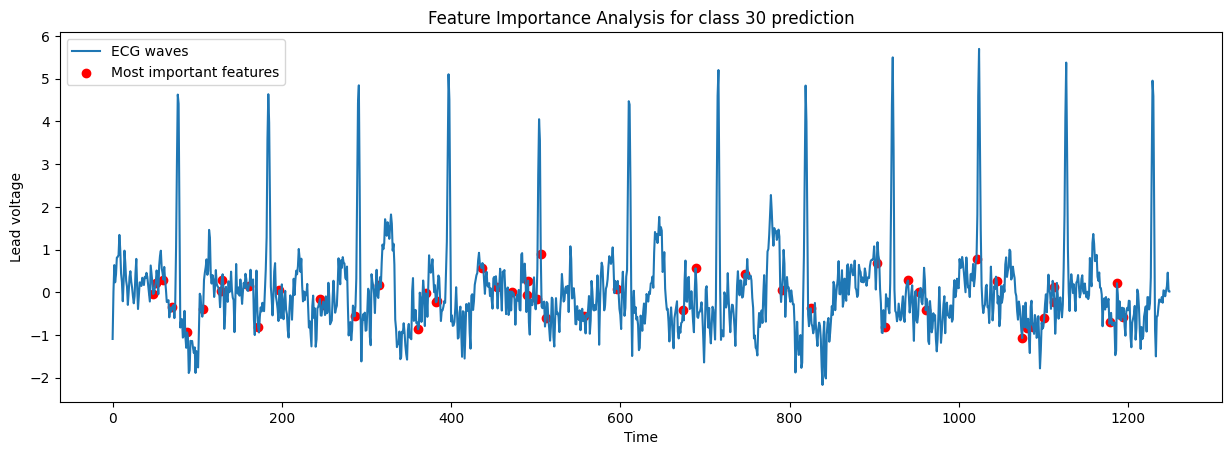


Explain prediction for class 31:

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Top 30 feature contributions to class 31 prediction:

Feature 827 - Contribution value: 0.018402241624505964
Feature 1085 - Contribution value: 0.018396717742907267
Feature 765 - Contribution value: 0.017396766167343966
Feature 247 - Contribution value: 0.017246765670201537
Feature 355 - Contribution value: 0.016749455557326123
Feature 227 - Contribution value: 0.015634147854181647
Feature 1014 - Contribution value: 0.014853332109038294
Feature 1149 - Contribution value: 0.014647768875880306
Feature 974 - Contribution value: 0.014607298742264577
Feature 931 - Contribution value: 0.014529502454967695
Feature 274 - Contribution value: 0.014513251266102053
Feature 939 - Contribution value: 0.014340692250173398
Feature 635 - Contribution value: 0.01432797211685566
Feature 981 - Contribution value: 0.01415692097872359
Feature 993 - Contribution value: 0.014137669284122642
Feature 145 - Contribution value: 0.0141082

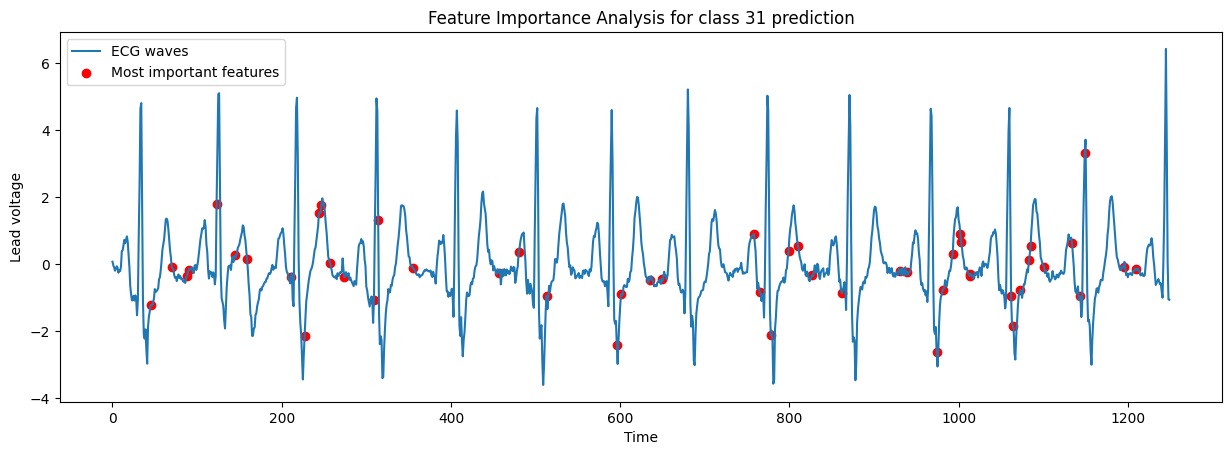

In [11]:

# Load model config.
reloaded_model = load_model("../modelconfig/v1_model.keras")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size = 0.1, stratify = y_array, random_state = 42)
X_train, y_train = apply_upsampling(X_train, y_train)
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test = X_test.reshape((X_test.shape[0], number_of_steps, number_of_features))

selected_samples = []
for classes_idx in range(32):
   found_idxs = [i for i, x in enumerate(y_train) if x == classes_idx][:1000]
   selected_samples.extend(found_idxs)
X_background = X_train[selected_samples]
y_background = y_train[selected_samples]
feature_names = [str(x) for x in range(1250)]
class_names = [str(x) for x in range(32)]

# Select one sample of each class to explain.
y_pred_prob = reloaded_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
x_test_dict = dict()
for i, l in enumerate(y_test):
   if len(x_test_dict) == 32:
      break
   if l not in x_test_dict.keys() and y_pred[i] == y_test[i]:
      x_test_dict[l] = X_test[i]

# Explain model predictions.
X_background = X_background.reshape((X_background.shape[0], number_of_steps, number_of_features))
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_background, training_labels = y_background,
                                                        feature_names = feature_names, discretize_continuous = False,
                                                        feature_selection = "auto",
                                                        class_names = class_names)
list_of_steps = np.arange(start = 0, stop = 1250)
for classes_idx in range(32):
    print("\nExplain prediction for class {}:\n".format(classes_idx))
    exp = explainer.explain_instance(np.expand_dims(x_test_dict[classes_idx], axis = 0),
                                     reloaded_model.predict, num_features = 1250)
    sorted_data = sorted(exp.as_list(), key = lambda x : x[1], reverse = True)
    top_125 = sorted_data[:50]
    print("\nTop 30 feature contributions to class {} prediction:\n".format(classes_idx))
    top_125_features = []
    for tup_elem in top_125:
        feature_num = str(tup_elem[0]).replace("0_t-", "")
        print("Feature {} - Contribution value: {}".format(feature_num, tup_elem[1]))
        top_125_features.append(int(feature_num))
    print("\n")
    plt.figure().set_figwidth(15)
    plt.plot(list_of_steps, x_test_dict[classes_idx].flatten(), label="ECG waves")
    plt.scatter(list_of_steps[top_125_features], x_test_dict[classes_idx][top_125_features],
                color = "r", label = "Most important features")
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Lead voltage')
    plt.title('Feature Importance Analysis for class {} prediction'.format(classes_idx))
    plt.show()


#### Plot confusion matrix of model predictions.




Generating upsampling through SMOTE...
200000 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(0): 6250, np.int64(1): 6250, np.int64(2): 6250, np.int64(3): 6250, np.int64(4): 6250, np.int64(5): 6250, np.int64(6): 6250, np.int64(7): 6250, np.int64(8): 6250, np.int64(9): 6250, np.int64(10): 6250, np.int64(11): 6250, np.int64(12): 6250, np.int64(13): 6250, np.int64(14): 6250, np.int64(15): 6250, np.int64(16): 6250, np.int64(17): 6250, np.int64(18): 6250, np.int64(19): 6250, np.int64(20): 6250, np.int64(21): 6250, np.int64(22): 6250, np.int64(23): 6250, np.int64(24): 6250, np.int64(25): 6250, np.int64(26): 6250, np.int64(27): 6250, np.int64(28): 6250, np.int64(29): 6250, np.int64(30): 6250, np.int64(31): 6250})
Finishing upsampling.

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


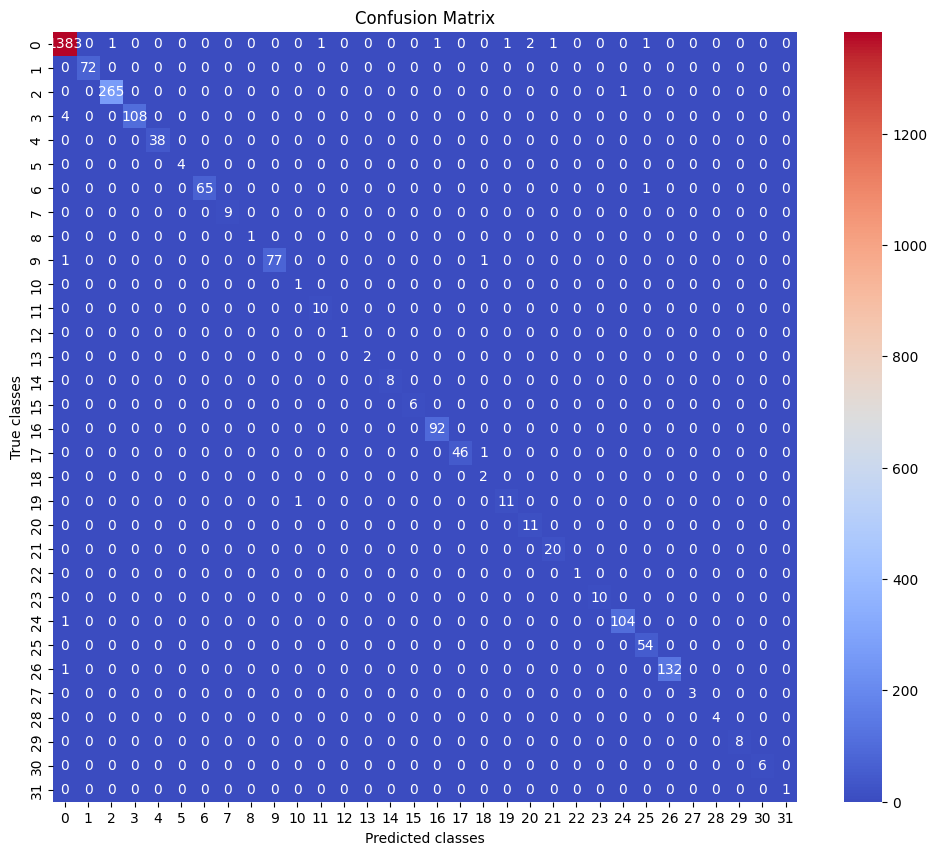

In [12]:

# Load model config.
reloaded_model = load_model("../modelconfig/v1_model.keras")
print("\n")

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size = 0.1, stratify = y_array, random_state = 42)
X_train, y_train = apply_upsampling(X_train, y_train)
scaler = PowerTransformer()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate confusion matrix.
y_pred_prob = reloaded_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
cm = confusion_matrix(y_test, y_pred)

# Plot a heatmap.
plt.figure(figsize = (12, 10))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "coolwarm")
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()
